# Web Mining -  Twitter User Gender Classification Project 

Name:

Roi Pillar 308292135

Imports:

In [2]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import re
import nltk
import emoji
import itertools
import urllib2
import re
import json
import string
from collections import Counter
import tweepy 

from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import words as nltk_words
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from gensim import models
from textblob import TextBlob


#classifiers:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


DATASET_PATH = 'gender-classifier-DFE-791531.csv'
PROFANITIES_PATH='profanities.txt'
stop = set(stopwords.words('english'))
tokenizer = TweetTokenizer()

## Question 1

First, i will read the dataset into a pandas Dataframe. Then i will pre-process the dataset in several different ways, then explore each of the pre-processing combinations.

### Text Pre-processing

In [3]:
# data = pd.read_csv(DATASET_PATH, encoding='utf-8',  index_col=False)#sep='\t' header=None,
data = pd.read_csv(DATASET_PATH, encoding='latin1',  index_col=False)#sep='\t' header=None,

df = pd.DataFrame(data)

df.head(10)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/05/2013 01:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.590000e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/01/2012 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,â°ï¢Ö¿It felt like they were my friends and ...,NaN,7471,10/26/15 12:40,6.590000e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.590000e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,06/11/2009 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.590000e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.590000e+17,NaN,NaN
5,815719231,False,finalized,3,10/27/15 1:47,female,1.0000,yes,1.0,03/11/2010 18:14,...,https://pbs.twimg.com/profile_images/656336865...,0,0,"Ive seen people on the train with lamps, chair...",NaN,20036,10/26/15 12:40,6.590000e+17,New York Gritty,Central Time (US & Canada)
6,815719232,False,finalized,3,10/27/15 1:57,brand,1.0000,yes,1.0,4/24/08 13:03,...,https://pbs.twimg.com/profile_images/528547133...,0,0,@BpackEngineer Thank you for your patience whi...,NaN,13354,10/26/15 12:40,6.590000e+17,Worldwide,Eastern Time (US & Canada)
7,815719233,False,finalized,3,10/26/15 23:48,male,1.0000,yes,1.0,12/03/2012 21:54,...,https://pbs.twimg.com/profile_images/508875440...,0,C0DEED,Gala Bingo clubs bought for ×Â£241m: The UK's...,NaN,112117,10/26/15 12:40,6.590000e+17,NaN,NaN
8,815719234,False,finalized,3,10/27/15 1:52,female,1.0000,yes,1.0,09/08/2015 04:50,...,https://pbs.twimg.com/profile_images/658670112...,0,0,@_Aphmau_ the pic defines all mcd fangirls/fan...,NaN,482,10/26/15 12:40,6.590000e+17,NaN,NaN
9,815719235,False,finalized,3,10/27/15 1:49,female,1.0000,yes,1.0,5/13/11 3:32,...,https://pbs.twimg.com/profile_images/513327289...,0,FFFFFF,@Evielady just how lovely is the tree this yea...,NaN,26085,10/26/15 12:40,6.590000e+17,"Nottingham, England.",Amsterdam


In [4]:
#filtering out some columns that we will not use:
df.drop(['_golden','_unit_state','_trusted_judgments','_last_judgment_at','profile_yn','profile_yn:confidence',
        'created','fav_number','gender_gold','profile_yn_gold','profileimage','retweet_count','tweet_coord',
        'tweet_count','tweet_created','tweet_id','tweet_location','user_timezone'], axis=1,inplace=True)

df.head(10)

,_unit_id,gender,gender:confidence,description,link_color,name,sidebar_color,text
0,815719226,male,1.0000,i sing my own rhythm.,08C2C2,sheezy0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,815719227,male,1.0000,I'm the author of novels filled with family dr...,0084B4,DavdBurnett,C0DEED,â°ï¢Ö¿It felt like they were my friends and ...
2,815719228,male,0.6625,louis whining and squealing and all,ABB8C2,lwtprettylaugh,C0DEED,i absolutely adore when louis starts the songs...
3,815719229,male,1.0000,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",0084B4,douggarland,C0DEED,Hi @JordanSpieth - Looking at the url - do you...
4,815719230,female,1.0000,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,3B94D9,WilfordGemma,0,Watching Neighbours on Sky+ catching up with t...
5,815719231,female,1.0000,you don't know me.,F5ABB5,monroevicious,0,"Ive seen people on the train with lamps, chair..."
6,815719232,brand,1.0000,"A global marketplace for images, videos and mu...",298AAE,Shutterstock,0,@BpackEngineer Thank you for your patience whi...
7,815719233,male,1.0000,The secret of getting ahead is getting started.,0000FF,RobinMeske,C0DEED,Gala Bingo clubs bought for ×Â£241m: The UK's...
8,815719234,female,1.0000,Pll Fan // Crazy about MCD // Ramen is bae,9266CC,pigzilla_,0,@_Aphmau_ the pic defines all mcd fangirls/fan...
9,815719235,female,1.0000,"Renaissance art historian, University of Notti...",9266CC,GabrieleNeher,FFFFFF,@Evielady just how lovely is the tree this yea...


Some cleaning operations:

In [131]:
def fix_nan_description(description):
    if type(description) is float:
        return ''
#     if description.encode('latin-1').strip() == 'nan':
    if description is None or description is 'None' or description.strip() == 'nan':
        return ''
    return description

#for example:
fix_nan_description('nan ')
# fix_nan_description(None)

''

In [6]:
def stem(text):
    tokens = tokenizer.tokenize(text)
    ps = PorterStemmer()
    
    tokens = [ps.stem(token) for token in tokens]
    
    return ' '.join(tokens)

#for example:
stem('regardless of context, their affection seemed non-existant')

u'regardless of context , their affect seem non-exist'

In [7]:
def remove_stop_words(text):
    tokens = tokenizer.tokenize(text)
    stop = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop]
    
    return ' '.join(tokens)

#for example:
remove_stop_words('regardless of context, their affection seemed non-existant')


u'regardless context , affection seemed non-existant'

In [8]:
def remove_url(text):    
    return re.sub(r'https?:\S+', '', text)

#for example:
remove_url('for more info on http, enter http://www.http.com (lo beshabat)')

'for more info on http, enter  (lo beshabat)'

In [9]:
def remove_punctuation(text):
    tokens = [token for token in tokenizer.tokenize(text) if token not in string.punctuation]
    return ' '.join(tokens)

remove_punctuation('for more info on http, enter http://www.http.com (lo beshabat)')

u'for more info on http enter http://www.http.com lo beshabat'

In [10]:
def remove_hashtags(text,mode):  
    if mode == 'entire_expression':
        return re.sub(r'#\S+', '', text)
    elif mode == 'only_symbol':
        return text.replace('#','')
    else:
        return text

#for example:
remove_hashtags('what did you think about the # of voters this year? use #VotersUnite to let us know.','entire_expression')

'what did you think about the # of voters this year? use  to let us know.'

In [11]:
remove_hashtags('#fridaymadness #nature #fun #outdoor #originalperson','only_symbol')

'fridaymadness nature fun outdoor originalperson'

In [12]:
def remove_ats(text,mode):
    if mode == 'entire_expression':
        return re.sub(r'@\S+', '', text)
    elif mode == 'only_symbol':
        return str(text).replace('@','')
    else:
        return text
    
#for example:
remove_ats('@ameliaearhart vs @WrightBrothers in an all exclusive fly-off','entire_expression')

' vs  in an all exclusive fly-off'

In [13]:
remove_ats('@ameliaearhart vs @WrightBrothers in an all exclusive fly-off','only_symbol')

'ameliaearhart vs WrightBrothers in an all exclusive fly-off'

In [14]:
def remove_multiple_spaces(text):    
    return re.sub(r' +', ' ', text).strip()

#for example:
remove_multiple_spaces(' @ameliaearhart       vs   @WrightBrothers in an all   exclusive fly-off ')

'@ameliaearhart vs @WrightBrothers in an all exclusive fly-off'

And the main preprocessing function:

In [15]:
def preprocess(df, min_confidence=0.9, should_lower=False, should_stem=False, should_remove_stop_words=False, should_remove_url=False,
                              should_remove_punctuation=False,should_remove_hashtags='only_symbol',should_remove_ats='entire_expression'):
    
    #first, some basic cleaning (remove rows that aren't informative enough)
    
    cleaner_df = df.loc[(df['gender'] != 'nan') & (df['text'] != 'nan') & (df['gender'] != 'unknown')]
    
    cleaner_df = cleaner_df[df['gender:confidence'] >= min_confidence]
            
    
    
    cleaner_df['description'] = [fix_nan_description(desc) for desc in cleaner_df['description']]

    if should_lower:
        cleaner_df['description'] = [desc.lower() for desc in cleaner_df['description']]
        cleaner_df['text'] = [text.lower() for text in cleaner_df['text']]


    if should_remove_url:
        cleaner_df['description'] = [remove_url(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_url(text) for text in cleaner_df['text']]
        
    if should_remove_punctuation:
        cleaner_df['description'] = [remove_punctuation(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_punctuation(text) for text in cleaner_df['text']]    
        
    if should_remove_hashtags!='none':
        cleaner_df['description'] = [remove_hashtags(desc,should_remove_hashtags) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_hashtags(text,should_remove_hashtags) for text in cleaner_df['text']]
        
    if should_remove_ats!='none':
        cleaner_df['description'] = [remove_ats(desc,should_remove_ats) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_ats(text,should_remove_ats) for text in cleaner_df['text']]
          
    if should_remove_stop_words:
        cleaner_df['description'] = [remove_stop_words(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_stop_words(text) for text in cleaner_df['text']]


    if should_stem:
        cleaner_df['description'] = [stem(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [stem(text) for text in cleaner_df['text']]
        

    #remove multiple spaces
    cleaner_df['description'] = [remove_multiple_spaces(desc) for desc in cleaner_df['description']]#str()?
    cleaner_df['text'] = [remove_multiple_spaces(text) for text in cleaner_df['text']]
    
    cleaner_df['text_desc'] = [desc+' '+text for desc,text in zip(cleaner_df['description'],cleaner_df['text'])]

    
    return cleaner_df


Note: removing all punctuation seems very weak, because we would then lose some very informative gender tendencies that our feature selection would capture (e.g <3 , assorted emojis and smilies, perhaps even an inclination to use more punctuation by one of the genders - this suspicion would be confirmed when features have been extracted and the results _with_ punctuation as a feature would be better than those _without_ punctuation).

In [16]:
clean_df = preprocess(df)
clean_df['text'][:20]

W:\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0     Robbie E Responds To Critics After Win Against...
1     â°ï¢Ö¿It felt like they were my friends and ...
3     Hi - Looking at the url - do you use Don't typ...
4     Watching Neighbours on Sky+ catching up with t...
5     Ive seen people on the train with lamps, chair...
6     Thank you for your patience while we take care...
7     Gala Bingo clubs bought for ×Â£241m: The UK's...
8     the pic defines all mcd fangirls/fanboys and m...
9     just how lovely is the tree this year! Never s...
11    MTG Deals 1x Rank-Up-Magic - The Seventh One -...
13    https://t.co/z4sbWUugd8 What the Nation Will B...
15    https://t.co/EROGWTFTYo It's a glow of satisfa...
16    lmao _ï¢×§×_ï¢×§× dude I'm hella scared fo...
17    Ditto - I'm still learning the favourites and ...
18    I do but I don't understand how to get to the ...
20                           thank you for the retweets
21    All the girls went to sleep and the guys just ...
22    I'm on the right side_ï¢×§×â°Ö¿Ö¾_ï¢Â

As we can see, we requested 20 elements and got elements up until index 24, which means some tweets were deleted (those who were not informative enough, and there are no hashtags anywhere (default configuration of preprocess removes them), and entire @ expressions were removed, like in row number 18 - that row was originally a response to some @user.

And if we were to want URLs to be removed:

In [17]:
preprocess(df,should_remove_url=True)['text'][:20]

W:\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0     Robbie E Responds To Critics After Win Against...
1     â°ï¢Ö¿It felt like they were my friends and ...
3     Hi - Looking at the url - do you use Don't typ...
4     Watching Neighbours on Sky+ catching up with t...
5     Ive seen people on the train with lamps, chair...
6     Thank you for your patience while we take care...
7     Gala Bingo clubs bought for ×Â£241m: The UK's...
8     the pic defines all mcd fangirls/fanboys and m...
9     just how lovely is the tree this year! Never s...
11    MTG Deals 1x Rank-Up-Magic - The Seventh One -...
13    What the Nation Will Be Talking About After We...
15              It's a glow of satisfaction re The Glow
16    lmao _ï¢×§×_ï¢×§× dude I'm hella scared fo...
17    Ditto - I'm still learning the favourites and ...
18    I do but I don't understand how to get to the ...
20                           thank you for the retweets
21    All the girls went to sleep and the guys just ...
22    I'm on the right side_ï¢×§×â°Ö¿Ö¾_ï¢Â

In [18]:
print('Number of records, raw version: {}'.format(len(df['text'])))
print('Number of records, clean version: {}'.format(len(clean_df['text'])))


Number of records, raw version: 20050
Number of records, clean version: 13810


### Data Exploration

I will simultaniously explore the "raw" and "clean" versions of the dataset (the clean one being the one generated by the default configuration of the preprocessing method)

In [19]:
texts = df['text']
descriptions = df['description']
genders = df['gender']

clean_texts = clean_df['text']
clean_descriptions = clean_df['description']
clean_genders = clean_df['gender']
clean_genders

0          male
1          male
3          male
4        female
5        female
6         brand
7          male
8        female
9        female
11        brand
13        brand
15       female
16       female
17         male
18         male
20       female
21       female
22       female
23         male
24         male
25       female
28       female
30        brand
31         male
32       female
33         male
34        brand
35         male
36        brand
37       female
          ...  
20009    female
20010    female
20011     brand
20013      male
20014      male
20015    female
20018      male
20019      male
20020     brand
20021      male
20022      male
20025     brand
20026      male
20027      male
20028    female
20030     brand
20031      male
20032      male
20034     brand
20035    female
20036    female
20037      male
20039    female
20041     brand
20043      male
20044    female
20045    female
20046      male
20047      male
20049    female
Name: gender, Length: 13

#### Distribution of the number of tweets per gender:

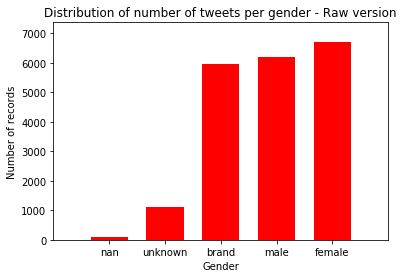

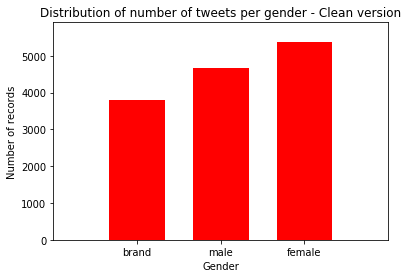

In [20]:
counter = Counter(genders)
clean_counter = Counter(clean_genders)


plt.title('Distribution of number of tweets per gender - Raw version')
plt.ylabel('Number of records')
plt.xlabel('Gender')
plt.axis([-1, len(counter), 0, 1.1*max(counter.values())])
plt.xticks(range(len(counter.keys())),counter.keys())
width = 1/1.5
plt.bar(range(len(counter)), counter.values(), width, color="red")

plt.show()

plt.title('Distribution of number of tweets per gender - Clean version')
plt.ylabel('Number of records')
plt.xlabel('Gender')
plt.axis([-1, len(clean_counter), 0, 1.1*max(clean_counter.values())])
plt.xticks(range(len(clean_counter.keys())),clean_counter.keys())
width = 1/1.5
plt.bar(range(len(clean_counter)), clean_counter.values(), width, color="red")

plt.show()


As we can see, a large number of records has been dropped following either no text data, or not enough confidence in the label assigned to them. This includes more than 1000 records labeled 'unknown', and about 1500 records labeled with any other gender with not enough confidence.

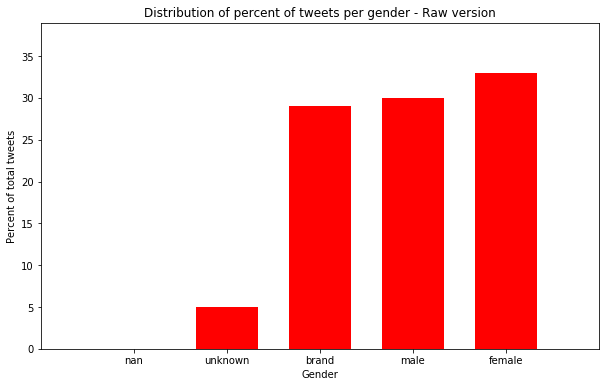

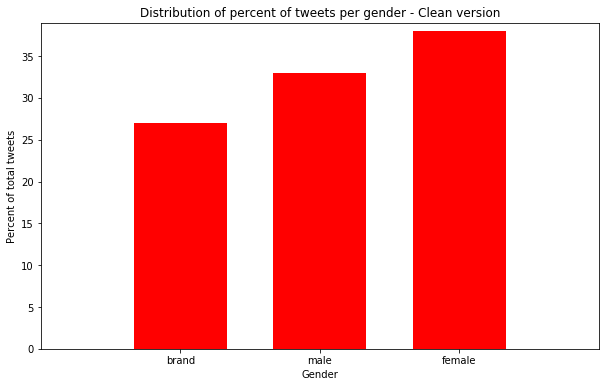

In [21]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

total_tweets = sum(counter.values())
clean_total_tweets = sum(clean_counter.values())

plt.title('Distribution of percent of tweets per gender - Raw version')
plt.ylabel('Percent of total tweets')
plt.xlabel('Gender')
plt.axis([-1, len(counter), 0, 1.3*30])
plt.xticks(range(len(counter.keys())),counter.keys())
width = 1/1.5
plt.bar(range(len(counter)), [100*num/total_tweets for num in counter.values()], width, color="red")

plt.show()

plt.title('Distribution of percent of tweets per gender - Clean version')
plt.ylabel('Percent of total tweets')
plt.xlabel('Gender')
plt.axis([-1, len(clean_counter), 0, 1.3*30])
plt.xticks(range(len(clean_counter.keys())),clean_counter.keys())
width = 1/1.5
plt.bar(range(len(clean_counter)), [100*num/clean_total_tweets for num in clean_counter.values()], width, color="red")

plt.show()





This is fairly balanced data.

#### Distribution of the number of tokens per tweet and description - overall and per gender, raw and clean data:

In [22]:
tweet_lengths = dict()
description_lengths = dict()
tweet_lengths_overall = []
description_lengths_overall = []

for gender in counter:
    tweet_lengths[gender]=[]
    description_lengths[gender]=[]
    
    
for tweet,desc,gender in zip(texts,descriptions,genders):

    tweet_length = len(tokenizer.tokenize(tweet))
    
    desc_length = len(tokenizer.tokenize(desc)) if type(desc) != float  else 0
    
    tweet_lengths[gender].append(tweet_length)
    description_lengths[gender].append(desc_length)
    tweet_lengths_overall.append(tweet_length)
    description_lengths_overall.append(desc_length)

    
    
clean_tweet_lengths = dict()
clean_description_lengths = dict()
clean_tweet_lengths_overall = []
clean_description_lengths_overall = []

for gender in clean_counter:
    clean_tweet_lengths[gender]=[]
    clean_description_lengths[gender]=[]
    
    
for tweet,desc,gender in zip(clean_texts,clean_descriptions,clean_genders):
    tweet_length = len(tokenizer.tokenize(tweet))
    
    desc_length = len(tokenizer.tokenize(desc)) if type(desc) != float  else 0
    
    clean_tweet_lengths[gender].append(tweet_length)
    clean_description_lengths[gender].append(desc_length)
    clean_tweet_lengths_overall.append(tweet_length)
    clean_description_lengths_overall.append(desc_length)


description_lengths['female']  

[29,
 5,
 12,
 28,
 6,
 16,
 0,
 14,
 23,
 16,
 3,
 15,
 8,
 8,
 4,
 21,
 11,
 34,
 14,
 4,
 9,
 24,
 38,
 7,
 29,
 17,
 19,
 5,
 57,
 37,
 2,
 0,
 8,
 13,
 37,
 28,
 289,
 6,
 0,
 9,
 2,
 25,
 24,
 30,
 28,
 14,
 27,
 16,
 15,
 29,
 0,
 9,
 24,
 39,
 36,
 24,
 27,
 0,
 0,
 25,
 3,
 5,
 3,
 32,
 20,
 14,
 19,
 33,
 13,
 26,
 26,
 29,
 0,
 3,
 5,
 9,
 37,
 37,
 52,
 41,
 4,
 15,
 17,
 3,
 8,
 2,
 15,
 8,
 15,
 21,
 8,
 8,
 5,
 4,
 27,
 27,
 15,
 16,
 33,
 23,
 25,
 29,
 10,
 43,
 29,
 15,
 15,
 23,
 24,
 3,
 5,
 0,
 3,
 42,
 13,
 9,
 18,
 9,
 3,
 0,
 1,
 23,
 0,
 0,
 0,
 21,
 2,
 0,
 0,
 18,
 11,
 29,
 21,
 25,
 14,
 0,
 2,
 6,
 0,
 24,
 3,
 6,
 8,
 15,
 23,
 7,
 5,
 41,
 5,
 0,
 64,
 4,
 4,
 0,
 0,
 16,
 6,
 18,
 32,
 0,
 25,
 0,
 0,
 16,
 7,
 8,
 14,
 22,
 0,
 46,
 3,
 0,
 0,
 26,
 25,
 11,
 9,
 3,
 0,
 0,
 8,
 35,
 10,
 24,
 15,
 19,
 8,
 0,
 30,
 5,
 24,
 24,
 1,
 2,
 3,
 27,
 28,
 11,
 0,
 43,
 1,
 24,
 13,
 0,
 6,
 35,
 0,
 1,
 0,
 13,
 1,
 28,
 0,
 13,
 74,
 11,
 30,
 37,
 21,
 3

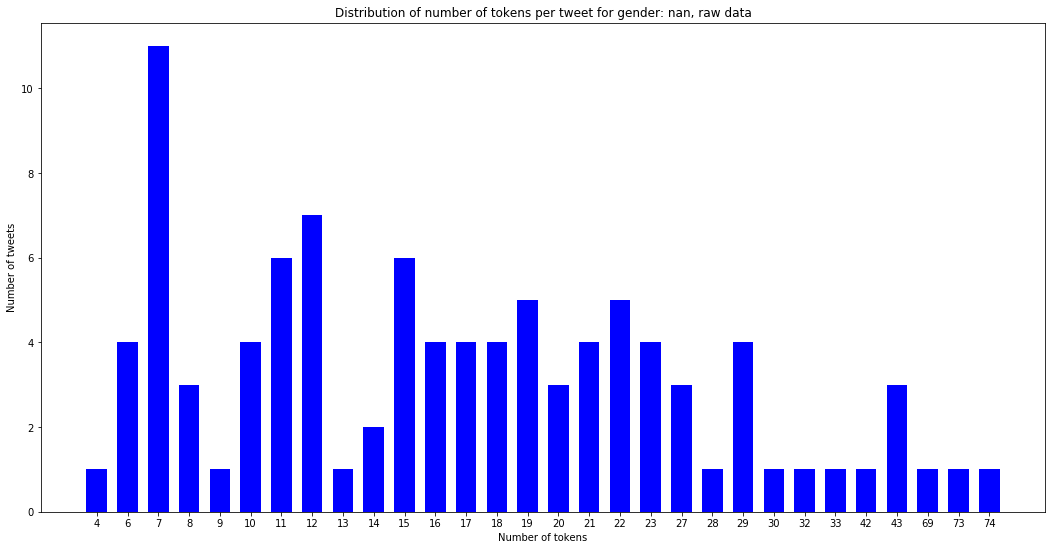

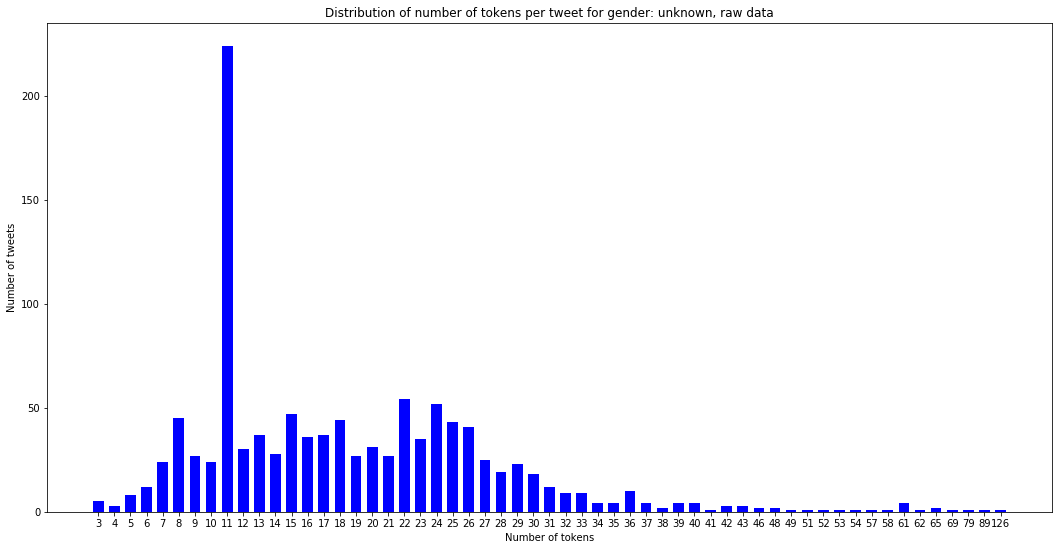

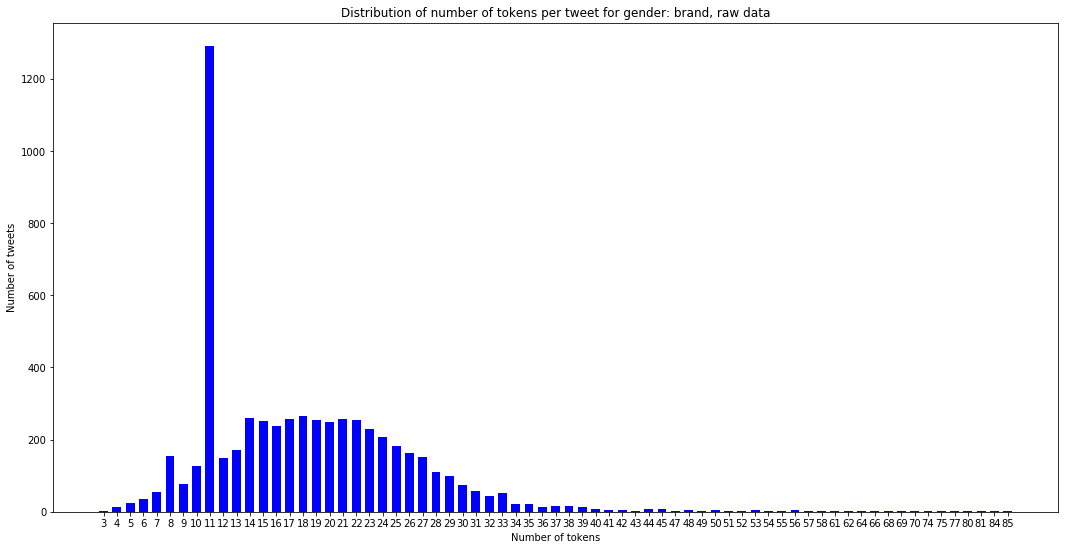

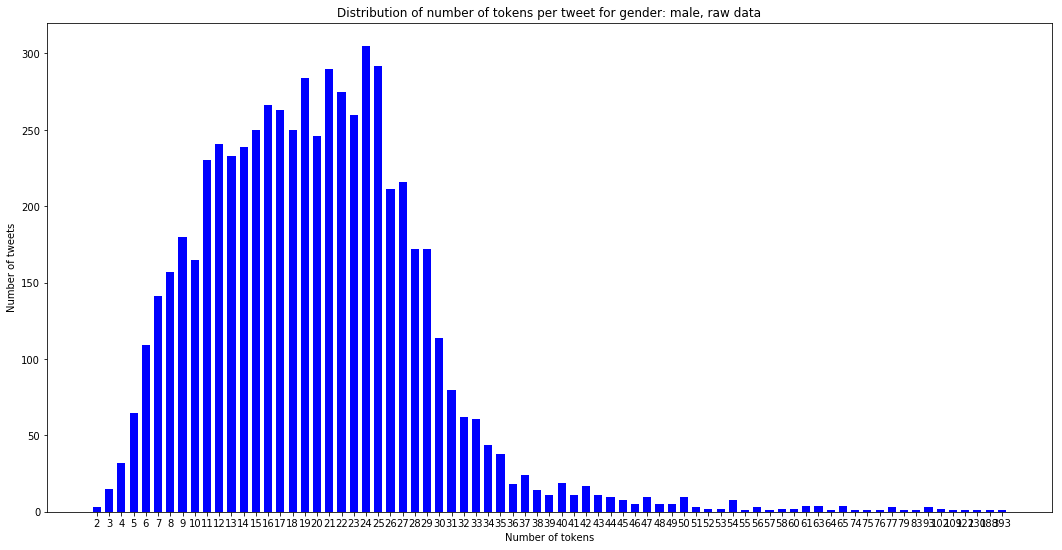

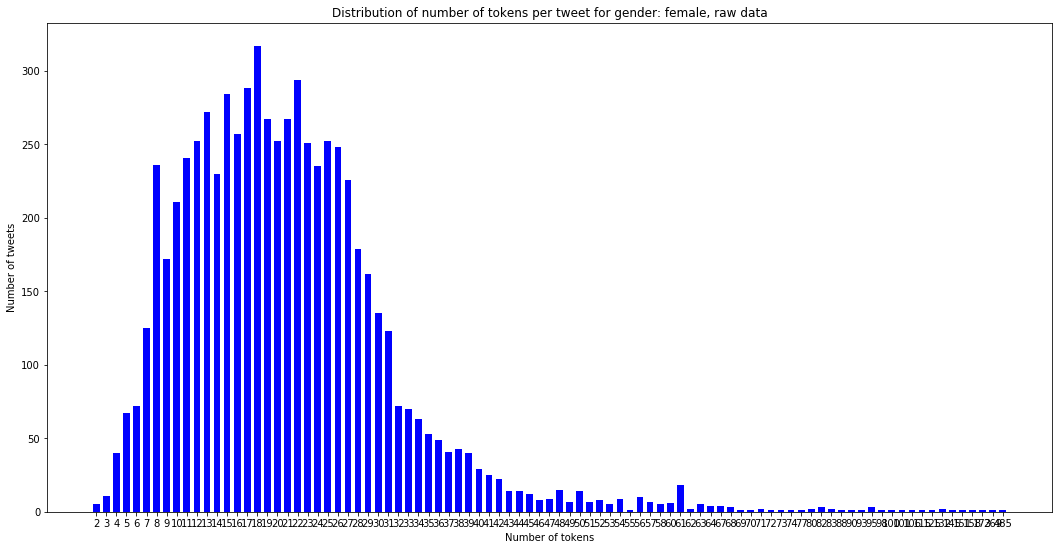

In [23]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

for gender in tweet_lengths.keys():
    counter_lengths = Counter(tweet_lengths[gender])
    
    xs = sorted(counter_lengths.keys())
    
    ys = [counter_lengths[tweet_length] for tweet_length in xs]
    
    plt.title('Distribution of number of tokens per tweet for gender: {}, raw data'.format(gender))
    plt.ylabel('Number of tweets')
    plt.xlabel('Number of tokens')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="blue")

    plt.show()

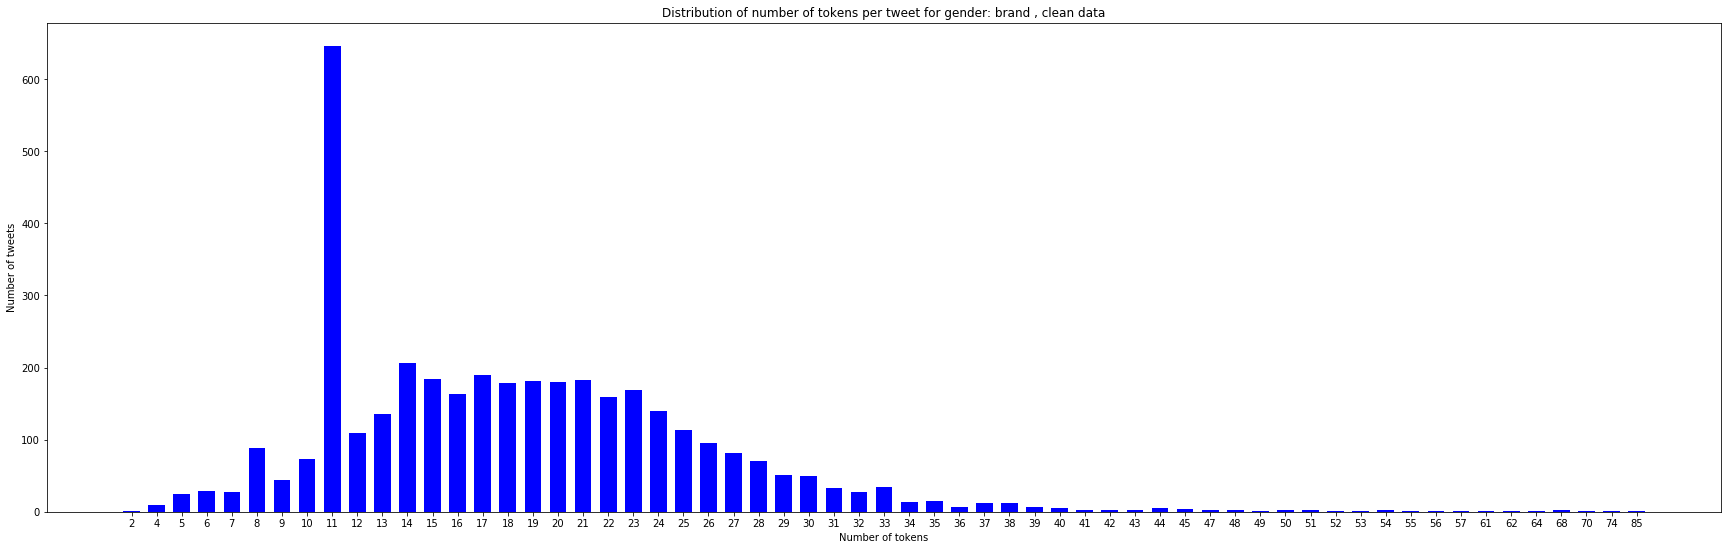

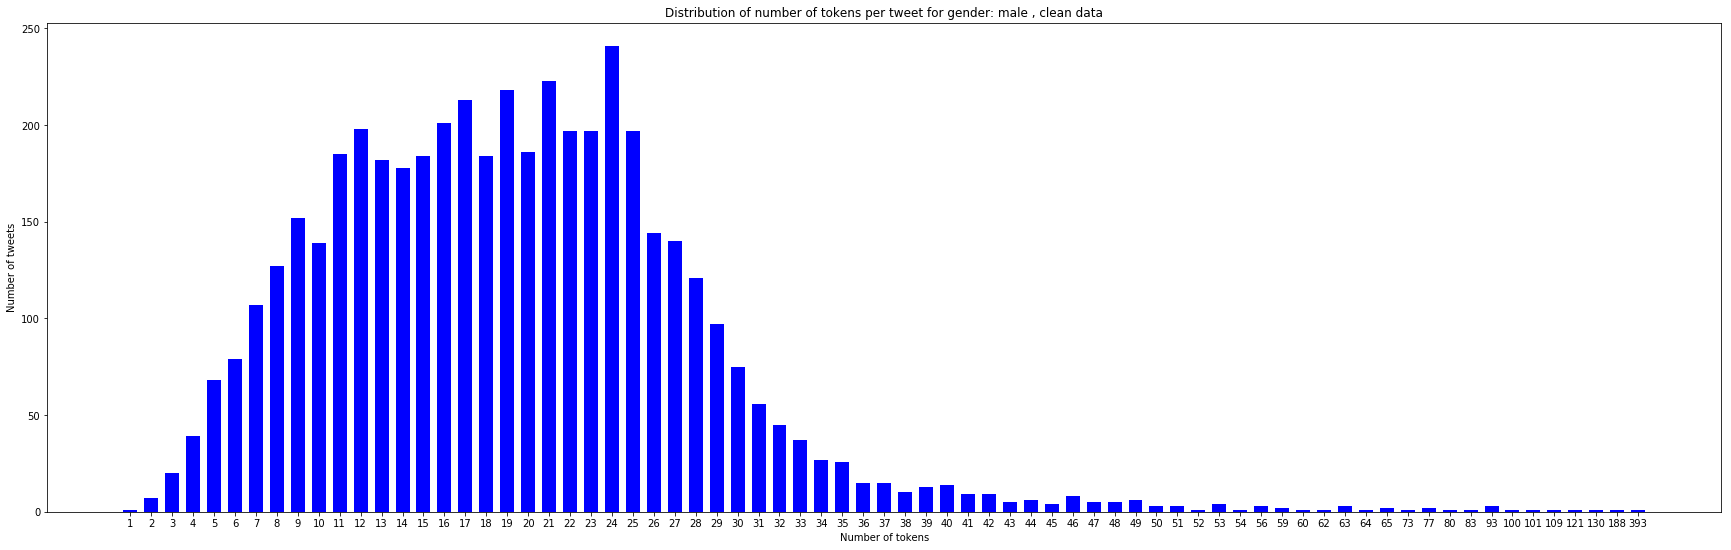

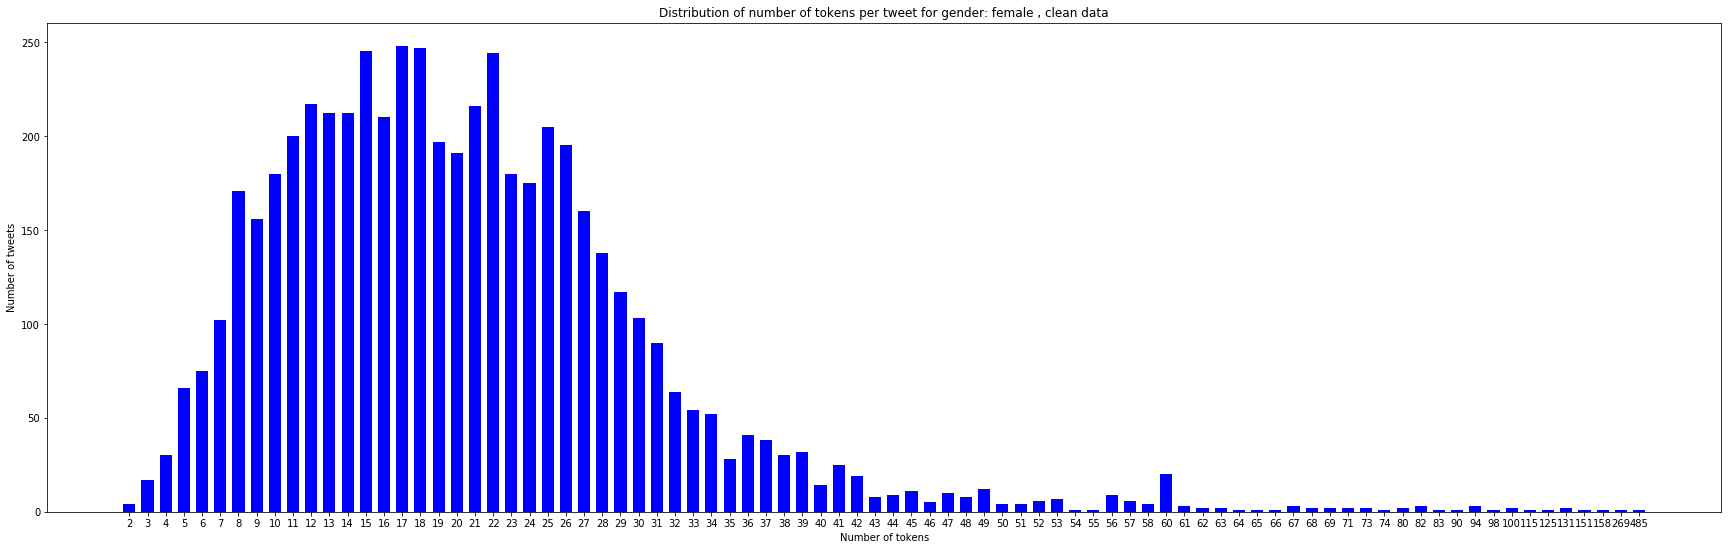

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

for gender in clean_tweet_lengths.keys():
    counter_lengths = Counter(clean_tweet_lengths[gender])
    
    xs = sorted(counter_lengths.keys())
    
    ys = [counter_lengths[tweet_length] for tweet_length in xs]
    
    plt.title('Distribution of number of tokens per tweet for gender: {} , clean data'.format(gender))
    plt.ylabel('Number of tweets')
    plt.xlabel('Number of tokens')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="blue")

    plt.show()

We observe an unusually high concentration of tweets of length 11 from the unknown and brand genders. (even in the preprocessed data!)
Let's investigate:

In [25]:
for tweet,gender in zip(texts,genders):
    if len(tokenizer.tokenize(tweet)) == 11 and gender == 'unknown':
        print('\n\n'+tweet)



It's the Final Countdown (to @PlayOverwatch Beta)! https://t.co/OLc7AnXJte


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@itsdileyswift @LucySwift26 @musicnews_facts @ddlovato @nickjonas and the rest of the planets


The Pretty Reckless - Heaven Knows (still cut) https://t.co/Lt9Jdssdw1


I'm tryna go to the midnight release of Halo 5 !


Get Weather Updates from The Weather Channel. 15:40:13


Get Weather Updates from The Weather Channel. 15:40:12


Get Weather Updates from The Weather Channel. 15:40:11


Get Weather Updates from The Weather Channel. 15:40:11


Get Weather Updates from The Weather Channel. 15:40:11


Get Weather Updates from The Weather Channel. 15:40:11


Get Weather Updates from The Weather Channel. 15:40:10


Ge



Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Get Weather Updates from The Weather Channel. 15:39:59


Passed the Infatuation phase _ï¢×§Â


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:58


Get Weather Updates from The Weather Channel. 15:39:57


Get Weather Updates from The Weather Channel. 15:39:57


Get Weather Updates from The Weather Channel. 

There seem to be some spam tweets, we will want to clean this out by rennovating our preprocessing function.

In [26]:
for tweet,gender in zip(texts,genders):
    if len(tokenizer.tokenize(tweet)) == 11 and gender == 'brand':
        print('\n\n'+tweet) 



The Wildcats pay a visit to Fain elementary school! https://t.co/Xjx8GNyRhJ


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


@onedirection Favorite Duo or Group Pop/Rock at the #AMAs


It must be so good being at the premiere! #SPECTRE


The students are ready for Governor Ricketts' presentation! https://t.co/h3tfnu3IQ1


Second Edition of the Wordaholix Scrabble League, #scrabble
https://t.co/RlUMAmI4Xc https://t.co/4yCa7wT9k0


Peers have voted to delay the governments Tax credit cuts 307-277


Instagramarama: 10 eye-popping atriums from around the world https://t.co/ZU3uxdlQYF https://t.co/gplJBvgHnU


Hunting the Wild Value-Add #Retail &gt;&gt; https://t.co/R329AfXMXn via 



Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:03


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:03


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The Weather Channel. 15:40:04


Get Weather Updates from The 



A new Begley Law Group article is now online - https://t.co/WnWQsrqtOc


What Black Lives Matter wants from @BernieSanders and @HillaryClinton: https://t.co/EjRjkUtt0s


Voices of America Past and Present, Volume I https://t.co/yYWLUP8DEk https://t.co/ag22zUsUIf


Marvel Announces INTERNATIONAL IRON MAN Series by Bendis and Maleev https://t.co/4uutCqU1Ex


@Mischief_Rises @gameragodzilla I like both 3 and 4. Forget y'all


Assistant Director of Security - Arizona Biltmore Resort &amp; Spa https://t.co/mXbIDzFMbL


HUGE list of #teacher #rewards and #discounts! https://t.co/TNZr7F5qYR https://t.co/49lb5UUmNE https://t.co/u4TW35hqUQ


Voices of America Past and Present, Volume I https://t.co/XlxkthUIRo https://t.co/LE7Goxbk4T


1876 2 Vols Life and Letters of Lord MACAULAY https://t.co/352z7S9qt7 https://t.co/xaWdVEFVke


Wednesday - #IslamicEvent Islam and Black History - #Newcastle @iERAorg https://t.co/mL5FrvbBlj


Find the nearest church and PRAY FOR THIS BITCH.  https://t.co/HpPnc

Some more spam here.

In [27]:
for tweet,gender in zip(texts,genders):
    if len(tokenizer.tokenize(tweet)) == 24 and gender == 'male':
        print('\n\n'+tweet)



he needs his own intro for when you pick up the phone 'CLIFFORD ELLIS, THE GREATEST BROCKER IN THE WORLD' lmfao


At Steidl &amp; Steinberg, we understand that owing #money to the #IRS or the state is scary. We can help: https://t.co/riC1oHcD1A


Thanks @WinkMartindale for the shout out! Iâ°ï¢Ãm looking pretty good for 75! #FamousName https://t.co/UMrFosWY0u


@LikeImTayha IGht got you about to dm you the credits thing hold on real quick driving real quick got to log in my bmi


@RealDiscoDonnie because we got one from something not so wonderful getting cancelled as well. So we just gonna get the original refund?


@DumbCreationist There's NOTHING new in the paper or it would be pasted on every TV screen worldwide! It's the same unsubstantiated rot.


Prayers go out to Oklahoma State University cause last week 4 ppl died and 44 injured during the shooting at OSU homecoming parade.


Sochaux's @Jong22_ and Valenciennes' @PSlidja both in the France Football team of the week - two yo



@xBraiNshOcK that's assuming that the hug isn't getting tighter as you exhale. If someone is squeezing you, it's gonna get tighter!


AND ALSO IN BLACK. THATS @ResistantCore BY THE HOMIE @CoopRebel GO CHECK EM OUT PEEPS BEFORE THEY RUN OUT!!! https://t.co/djyQd6m8SE


I'd certainly respect @David_Cameron a lot more if he just admitted he doesn't give a fuck about the working people. I don't.


@fatherandrew I'm convinced that these Synod's are the last/best attempt at fraternal correction for visibly errant bishops.

O my Jesus...


IF WE STREAM AND REQUEST PERFECT ON THE RADIO, WE STILL KEEP IT ON THE CHARTS. @onedirection Artist Of The Year #AMAs


The Impudence of Rabiu Kwakwanso and his Fulani brothers - by FFK: Written by Femi Fani-Kayode...Read below..I... https://t.co/m8WvKg5WFY


A throwback to listening my first ever English music from my favourite band  - "In The End". Thank you @linkinpark  #HybridTheory15


The Impudence of Rabiu Kwakwanso and his Fulani brothers - by FFK



Looks great. Love the sounds of piano and all things from #neworleans I hope the tour is killing it! x @pianomalone  https://t.co/rXZrhwxHYV


Winter is coming and what better snack to have while bundled up than our delicious and nutritiousâ°ï¢_ https://t.co/1XWOBqiyGz


@Delwright365 @footballacca ok I called them and they told me bet voided. I'll try chat and see if they will pay out.


So many people selling dreams. Dreams remain dreams of there is no action. To go out there and give information... https://t.co/5ipSJ3yYzt


@VeniceMase Competive on a nightly basis, lots of minutes for young bucks, and acquire another young asset or extra draft pick.


@WOIOSports he's not having a good year. We could have kept TJ for less money and he's younger! #whywesuck #FireFarmer #dawgpound #browns


Me ha gustado un vÖ¼_deo de @YouTube (https://t.co/XHgfHxGdzx - Hearthstone: Kolento funny, lucky, troll and failfish moments OpieOP).


What the fuck. I for real just got rear ended into the c

and a bit more spam. ( The Impudence of Rabiu Kwakwanso and his Fulani brothers - by FFK: Written by Femi Fani-Kayode...Read below..I... https://t.co/OVv9M4mGBh )

Let's try and find the exact number of spam tweets in the dataset:

In [28]:
tweets_counter = Counter()
for tweet in texts:
    tweets_counter[tweet]+=1
    
tweets_counter.most_common(50)  

[(u'EVERYDAYILOVEYOU Forevermore\n\nand what makes it last\n\n#PushAwardsLizQuens',
  193),
 (u'Get Weather Updates from The Weather Channel. 15:40:07', 91),
 (u'Get Weather Updates from The Weather Channel. 15:40:06', 88),
 (u'Get Weather Updates from The Weather Channel. 15:40:05', 85),
 (u'Get Weather Updates from The Weather Channel. 15:40:08', 84),
 (u'Get Weather Updates from The Weather Channel. 15:40:03', 73),
 (u'Get Weather Updates from The Weather Channel. 15:39:55', 71),
 (u'Get Weather Updates from The Weather Channel. 15:39:53', 71),
 (u'Get Weather Updates from The Weather Channel. 15:40:09', 67),
 (u'Get Weather Updates from The Weather Channel. 15:40:04', 63),
 (u'Get Weather Updates from The Weather Channel. 15:39:58', 61),
 (u'Get Weather Updates from The Weather Channel. 15:40:00', 61),
 (u'Get Weather Updates from The Weather Channel. 15:39:57', 60),
 (u'Get Weather Updates from The Weather Channel. 15:39:59', 60),
 (u'Get Weather Updates from The Weather Channel. 

In [29]:
len([spam for spam in tweets_counter.keys() if tweets_counter[spam]>1])

105

I will consider all repeated tweets as spam. There are only 105 spam tweets, but the top spam tweets (weather updates, @onedirection) seem to take up a large percent of all records, let's check how much exactly:

In [30]:
100*sum([tweets_counter[spam] for spam in tweets_counter.keys() if tweets_counter[spam]>1])/float(len(texts))

8.703241895261845

Ok, 8.7% of all tweets are spam. Let's filter these out by re-implementing our preprocess function:

In [31]:
spams = list([tweet for tweet in tweets_counter.keys() if tweets_counter[tweet]>1])
spams

[u"You can fall in love many times with many different people. However, I don't think that you can fall in love the same way twice.",
 u'Keep your goals in front of you and your fears behind you. - Tony Robbins #quote',
 u'@ebwashington @binarybits OEM-owned Car2Go. OEMs and Tier 1s (or future suppliers--Google) likely in best position for AV subscription model',
 u"@leedsparadise his name is Tapsi and he's the laziest cat in history we've had him for four years",
 u"Discovered it in England. It's how they eat fish and chips.  Never went back to ketchup. https://t.co/tYIf6bZmX2",
 u'Dow, S&amp;P 500 ends down with energy, Apple: NEW YORK (Reuters) - The Dow and the S&amp;P 500 edged lower on Monday after recent gains as e...',
 u"You can't make time; so those who waste the least, achieve the most. - Tim Fargo #quote",
 u'#NAME?',
 u'Get Weather Updates from The Weather Channel. 15:40:13',
 u'Get Weather Updates from The Weather Channel. 15:40:12',
 u'Get Weather Updates from The Weathe

In [32]:
def preprocess(df, min_confidence=0.9, should_lower=False, should_stem=False, should_remove_stop_words=False, should_remove_url=False,
                            should_remove_punctuation=False,should_remove_hashtags='none',should_remove_ats='none'):
    
    #basic cleaning
    cleaner_df = df.loc[(df['gender'] != 'nan') & (df['text'] != 'nan') & (df['gender'] != 'unknown')]
    
    cleaner_df = cleaner_df[df['gender:confidence'] >= min_confidence]
            
    
    
    cleaner_df['description'] = [fix_nan_description(desc) for desc in cleaner_df['description']]

    
    #################################
    #removing spam tweets:
    cleaner_df.drop_duplicates(subset='text', keep='first', inplace=True)
    ##################################
    

    if should_lower:
        cleaner_df['description'] = [desc.lower() for desc in cleaner_df['description']]
        cleaner_df['text'] = [text.lower() for text in cleaner_df['text']]

    if should_remove_punctuation:
        cleaner_df['description'] = [remove_punctuation(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_punctuation(text) for text in cleaner_df['text']]

    if should_remove_url:
        cleaner_df['description'] = [remove_url(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_url(text) for text in cleaner_df['text']]
        
    if should_remove_hashtags!='none':
        cleaner_df['description'] = [remove_hashtags(desc,should_remove_hashtags) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_hashtags(text,should_remove_hashtags) for text in cleaner_df['text']]
        
    if should_remove_ats!='none':
        cleaner_df['description'] = [remove_ats(desc,should_remove_ats) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_ats(text,should_remove_ats) for text in cleaner_df['text']]
          
    if should_remove_stop_words:
        cleaner_df['description'] = [remove_stop_words(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [remove_stop_words(text) for text in cleaner_df['text']]


    if should_stem:
        cleaner_df['description'] = [stem(desc) for desc in cleaner_df['description']]
        cleaner_df['text'] = [stem(text) for text in cleaner_df['text']]
        

    #remove multiple spaces
    cleaner_df['description'] = [remove_multiple_spaces(desc) for desc in cleaner_df['description']]
    cleaner_df['text'] = [remove_multiple_spaces(text) for text in cleaner_df['text']]
    cleaner_df['text_desc'] = [desc+' '+text for desc,text in zip(cleaner_df['description'],cleaner_df['text'])]

    return cleaner_df

In [33]:
clean_df_no_spam = preprocess(df)
print('Number of records before spam removal: {}'.format(len(clean_df['text'])))
print('Number of records after spam removal: {}'.format(len(clean_df_no_spam['text'])))

W:\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Number of records before spam removal: 13810
Number of records after spam removal: 13165


In [34]:
clean_texts_no_spam = clean_df_no_spam['text']
clean_descriptions_no_spam = clean_df_no_spam['description']
clean_genders_no_spam = clean_df_no_spam['gender']

Let's report on the label frequencies after the change we introduced:

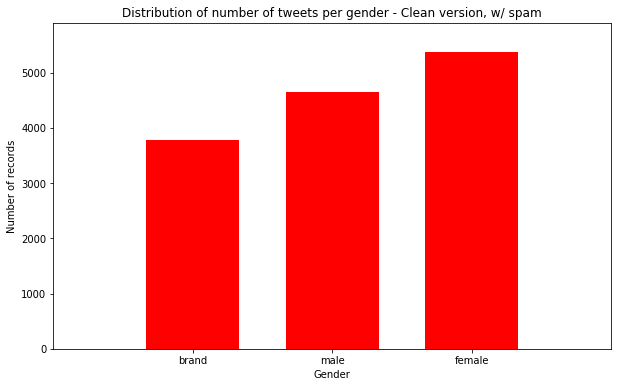

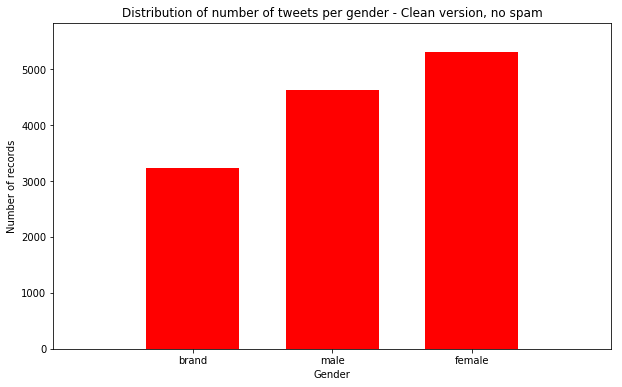

In [35]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.title('Distribution of number of tweets per gender - Clean version, w/ spam')
plt.ylabel('Number of records')
plt.xlabel('Gender')
plt.axis([-1, len(clean_counter), 0, 1.1*max(clean_counter.values())])
plt.xticks(range(len(clean_counter.keys())),clean_counter.keys())
width = 1/1.5
plt.bar(range(len(clean_counter)), clean_counter.values(), width, color="red")

plt.show()


clean_counter_no_spam = Counter(clean_genders_no_spam)


plt.title('Distribution of number of tweets per gender - Clean version, no spam')
plt.ylabel('Number of records')
plt.xlabel('Gender')
plt.axis([-1, len(clean_counter_no_spam), 0, 1.1*max(clean_counter_no_spam.values())])
plt.xticks(range(len(clean_counter_no_spam.keys())),clean_counter_no_spam.keys())
width = 1/1.5
plt.bar(range(len(clean_counter_no_spam)), clean_counter_no_spam.values(), width, color="red")

plt.show()


Not a HUGE difference (700~ tweets removed), but let's hope it will be substantial further on.

Lets observe the difference in token length distributions: 

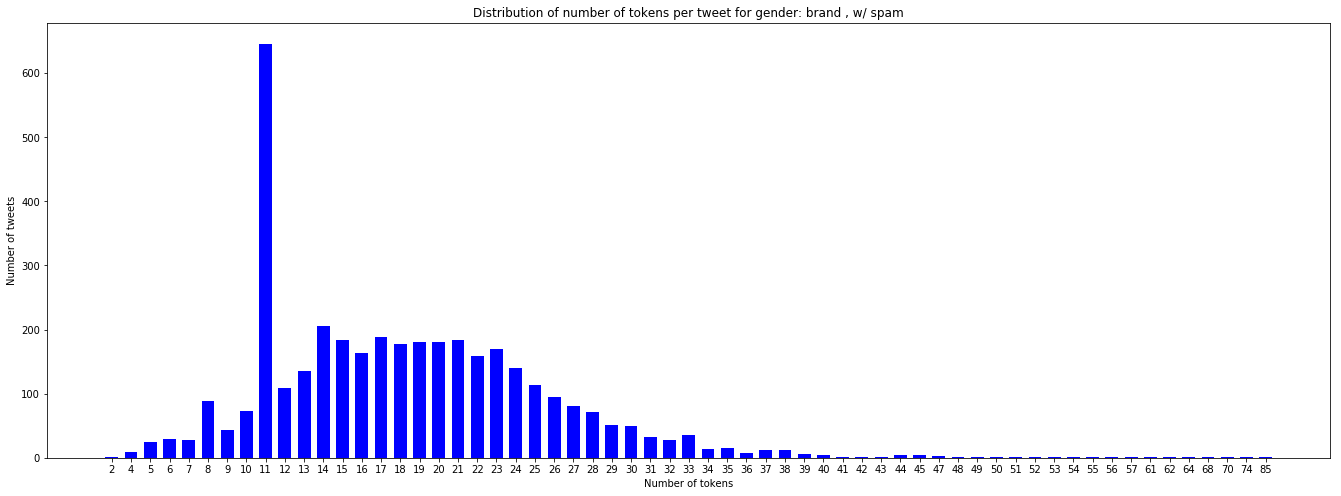

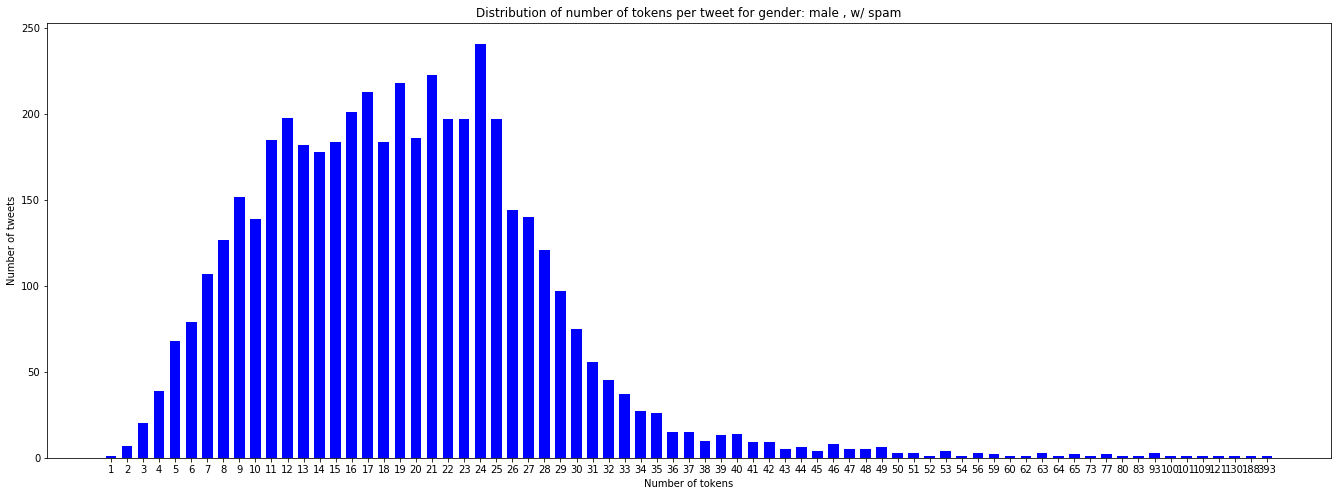

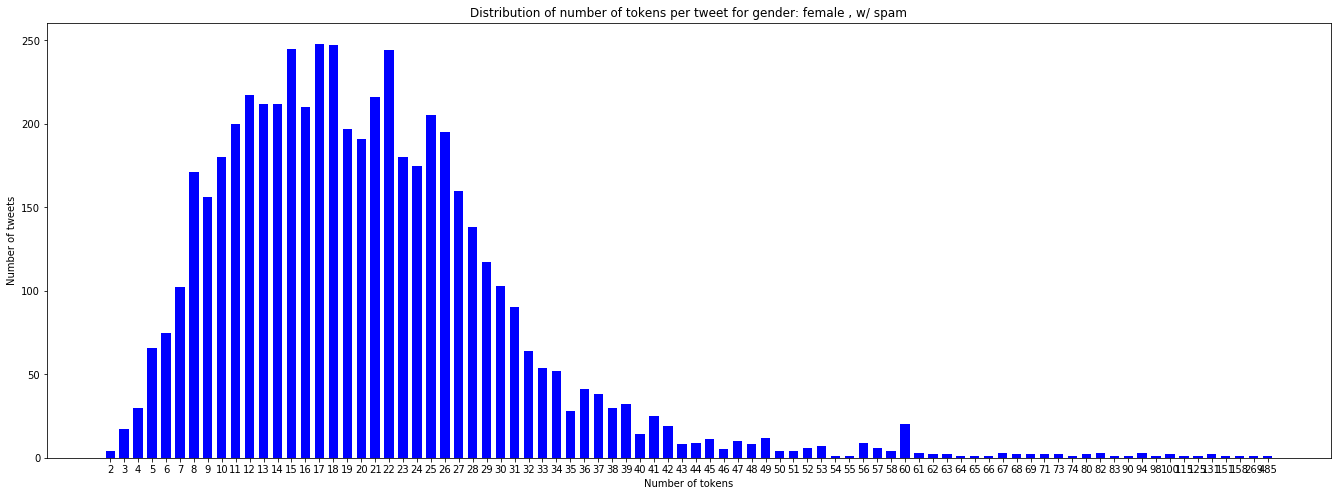

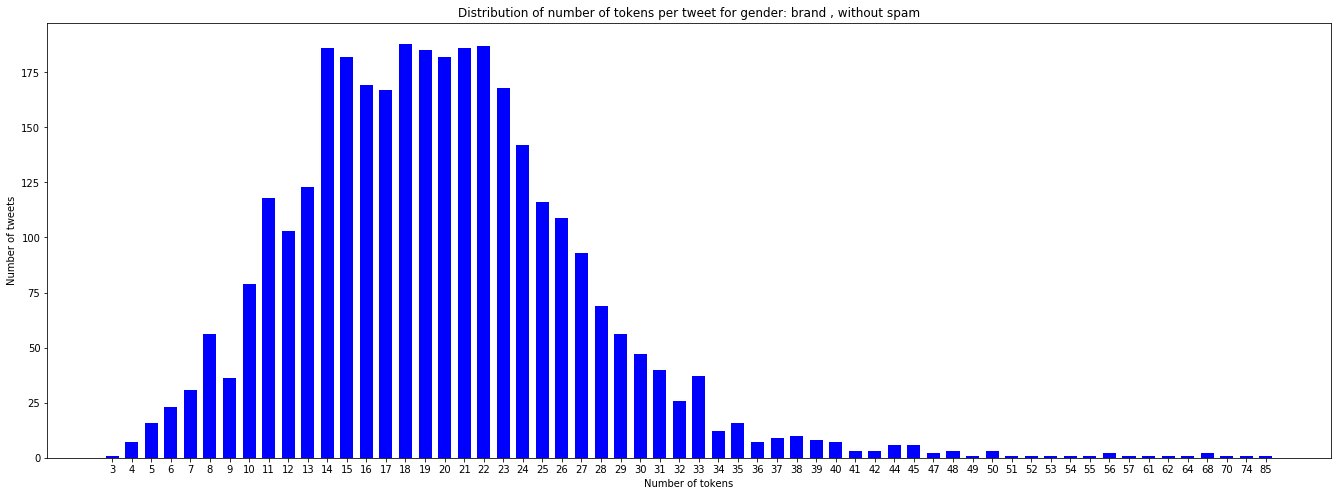

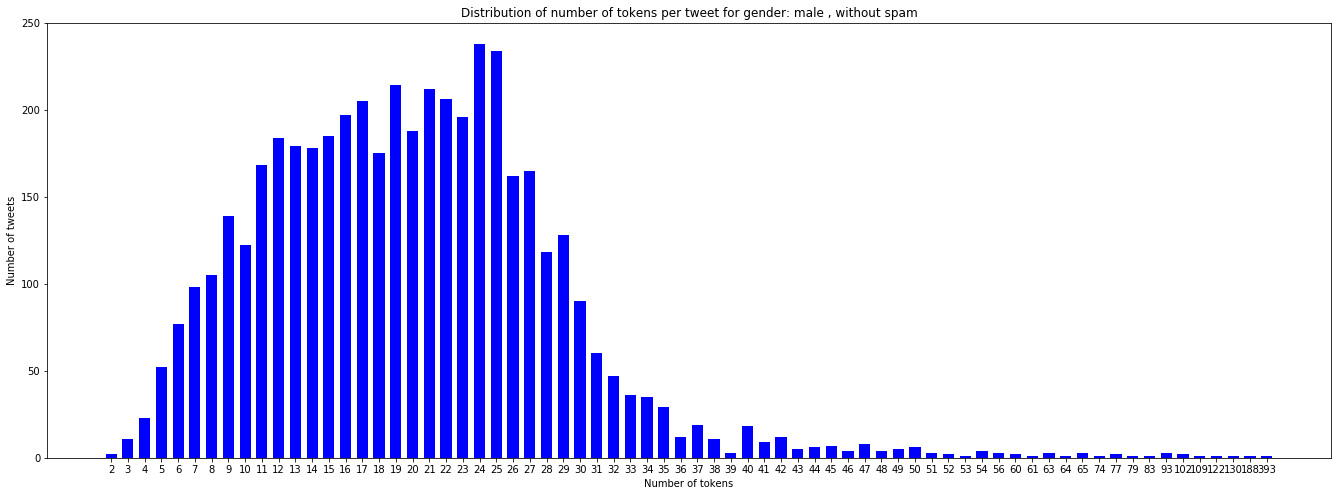

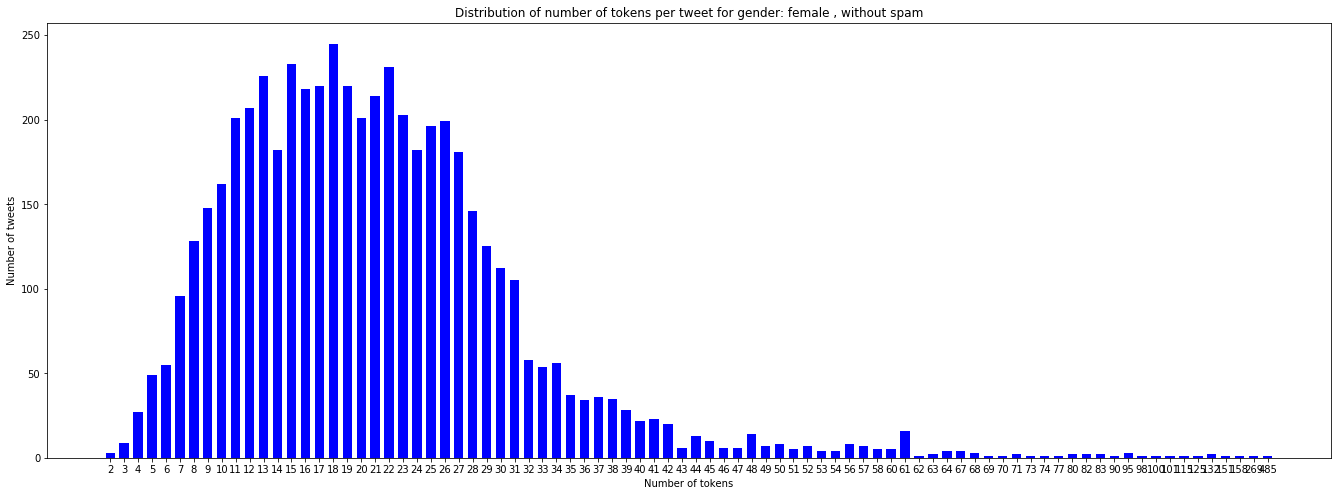

In [36]:
no_spam_clean_tweet_lengths = dict()
no_spam_clean_description_lengths = dict()
no_spam_clean_tweet_lengths_overall = []
no_spam_clean_description_lengths_overall = []

for gender in clean_counter_no_spam:
    no_spam_clean_tweet_lengths[gender]=[]
    no_spam_clean_description_lengths[gender]=[]
    
    
for tweet,desc,gender in zip(clean_texts_no_spam,clean_descriptions_no_spam,clean_genders_no_spam):
    tweet_length = len(tokenizer.tokenize(tweet))
    
    desc_length = len(tokenizer.tokenize(desc)) if type(desc) != float  else 0
    
    no_spam_clean_tweet_lengths[gender].append(tweet_length)
    no_spam_clean_description_lengths[gender].append(desc_length)
    no_spam_clean_tweet_lengths_overall.append(tweet_length)
    no_spam_clean_description_lengths_overall.append(desc_length)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 23
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size  


for gender in clean_tweet_lengths.keys():
    counter_lengths = Counter(clean_tweet_lengths[gender])
    
    xs = sorted(counter_lengths.keys())
    
    ys = [counter_lengths[tweet_length] for tweet_length in xs]
    
    plt.title('Distribution of number of tokens per tweet for gender: {} , w/ spam'.format(gender))
    plt.ylabel('Number of tweets')
    plt.xlabel('Number of tokens')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="blue")

    plt.show()
    
for gender in no_spam_clean_tweet_lengths.keys():
    counter_lengths = Counter(no_spam_clean_tweet_lengths[gender])
    
    xs = sorted(counter_lengths.keys())
    
    ys = [counter_lengths[tweet_length] for tweet_length in xs]
    
    plt.title('Distribution of number of tokens per tweet for gender: {} , without spam'.format(gender))
    plt.ylabel('Number of tweets')
    plt.xlabel('Number of tokens')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="blue")

    plt.show()

Looks better. 

In [37]:
males_lengths = tweet_lengths['male']
print('Raw data: Average number of tokens per tweet for males: {}'.format(sum(males_lengths)/len(males_lengths)))
females_lengths = tweet_lengths['female']
print('Raw data: Average number of tokens per tweet for females: {}'.format(sum(females_lengths)/len(females_lengths)))
brands_lengths = tweet_lengths['brand']
print('Raw data: Average number of tokens per tweet for brand : {}'.format(sum(brands_lengths)/len(brands_lengths)))
print('')

males_lengths = no_spam_clean_tweet_lengths['male']
print('Clean data: Average number of tokens per tweet for males: {}'.format(sum(males_lengths)/len(males_lengths)))
females_lengths = no_spam_clean_tweet_lengths['female']
print('Clean data: Average number of tokens per tweet for females: {}'.format(sum(females_lengths)/len(females_lengths)))
brands_lengths = no_spam_clean_tweet_lengths['brand']
print('Clean data: Average number of tokens per tweet for brand : {}'.format(sum(brands_lengths)/len(brands_lengths)))


Raw data: Average number of tokens per tweet for males: 20
Raw data: Average number of tokens per tweet for females: 21
Raw data: Average number of tokens per tweet for brand : 18

Clean data: Average number of tokens per tweet for males: 20
Clean data: Average number of tokens per tweet for females: 21
Clean data: Average number of tokens per tweet for brand : 19


Not very informative. It will be hard extracting features based on length of tweet.

From here on out, we will now only use the newer version of preprocess (with spam removal).

In [38]:
clean_df=clean_df_no_spam

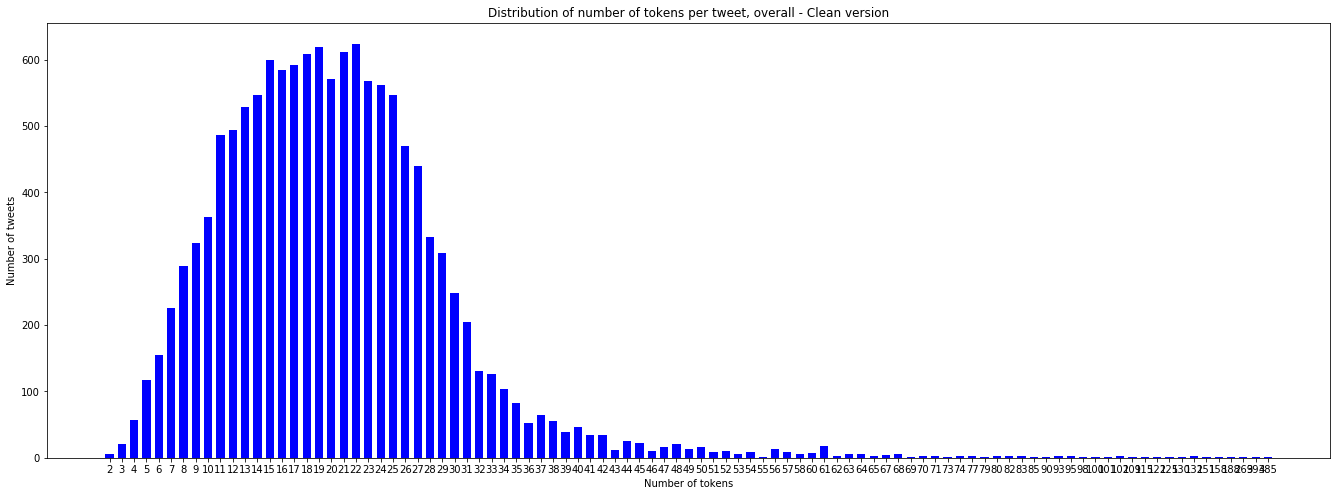

Average length of tweets over all categories: 20.0


In [39]:
counter_lengths = Counter(no_spam_clean_tweet_lengths_overall)

xs = sorted(counter_lengths.keys())

ys = [counter_lengths[tweet_length] for tweet_length in xs]

plt.title('Distribution of number of tokens per tweet, overall - Clean version')
plt.ylabel('Number of tweets')
plt.xlabel('Number of tokens')
plt.xticks(range(len(xs)),xs)
plt.bar(range(len(xs)), ys, width, color="blue")

plt.show()

avg_len = sum(no_spam_clean_tweet_lengths_overall)/len(no_spam_clean_tweet_lengths_overall)
print('Average length of tweets over all categories: {}'.format(round(avg_len,2)))

### Vocabulary size and number of tokens overall and per gender:

I'll create some data structures to make it easier:

In [40]:
def create_vocabulary_counters():
    vocabulary_per_gender_raw=dict()
    vocabulary_per_gender_clean=dict()
    vocabulary_overall_clean = ''
    
    for gender in clean_counter_no_spam:
        vocabulary_per_gender_clean[gender]=''

    for gender in counter:
        vocabulary_per_gender_raw[gender]=''


    for tweet,gender in zip(texts,genders):
        vocabulary_per_gender_raw[gender]+=tweet+' '
        
    for tweet,gender in zip(clean_texts_no_spam,clean_genders_no_spam):
        vocabulary_per_gender_clean[gender]+=tweet+' '
        vocabulary_overall_clean+=tweet+' '

    counter_vocabulary_per_gender_raw = dict()
    counter_vocabulary_per_gender_clean = dict()

    for gender in ['male','female','brand']:
        counter_vocabulary_per_gender_clean[gender] = Counter(tokenizer.tokenize(vocabulary_per_gender_clean[gender]))
        counter_vocabulary_per_gender_raw[gender] = Counter(tokenizer.tokenize(vocabulary_per_gender_raw[gender]))

    counter_vocabulary_overall = Counter(tokenizer.tokenize(vocabulary_overall_clean))
    
    return counter_vocabulary_per_gender_raw , counter_vocabulary_per_gender_clean , counter_vocabulary_overall

counter_vocabulary_per_gender_raw , counter_vocabulary_per_gender_clean , counter_vocabulary_overall = create_vocabulary_counters()

__Vocabulary size and number of tokens per gender:__

In [41]:
for gender in ['male','female','brand']:
    print('-'*10+'Raw dataset vocabulary statistics for {} gender '.format(gender)+'-'*10)
    vocab_size = len(counter_vocabulary_per_gender_raw[gender])
    print('Vocabulary size: {}'.format(vocab_size))

  

    while True:
        rand1=random.randint(0,vocab_size-1)
        rand2=random.randint(0,vocab_size-1)
        rand3=random.randint(0,vocab_size-1)
        try:
            print('Sampled words: "{}", "{}", "{}"'.format(list(counter_vocabulary_per_gender_raw[gender].keys())[rand1],
                                              list(counter_vocabulary_per_gender_raw[gender].keys())[rand2],
                                              list(counter_vocabulary_per_gender_raw[gender].keys())[rand3]))
            break
        except UnicodeEncodeError:
            continue
            
    print('Total number of tokens: {}\n'.format(sum(counter_vocabulary_per_gender_raw[gender].values())))

----------Raw dataset vocabulary statistics for male gender ----------
Vocabulary size: 22901
Sampled words: "Mula", "absolutely", "x8345"
Total number of tokens: 123898

----------Raw dataset vocabulary statistics for female gender ----------
Vocabulary size: 21442
Sampled words: "https://t.co/kgMaYBPBez", "@Quendrith", "eyB"
Total number of tokens: 140774

----------Raw dataset vocabulary statistics for brand gender ----------
Vocabulary size: 23227
Sampled words: "reserves", "Gangtok", "https://t.co/V6vmPy4Z70"
Total number of tokens: 107668



In [42]:
for gender in ['male','female','brand']:
    print('-'*10+'Clean dataset vocabulary statistics for {} gender '.format(gender)+'-'*10)
    vocab_size = len(counter_vocabulary_per_gender_clean[gender])
    print('Vocabulary size: {}'.format(vocab_size))

    while True:
        rand1=random.randint(0,vocab_size-1)
        rand2=random.randint(0,vocab_size-1)
        rand3=random.randint(0,vocab_size-1)
        try:
            print('Sampled words: "{}", "{}", "{}"'.format(list(counter_vocabulary_per_gender_clean[gender].keys())[rand1],
                                          list(counter_vocabulary_per_gender_clean[gender].keys())[rand2],
                                          list(counter_vocabulary_per_gender_clean[gender].keys())[rand3]))
            break
        except UnicodeEncodeError:
            continue
            
    print('Total number of tokens: {}\n'.format(sum(counter_vocabulary_per_gender_clean[gender].values())))

----------Clean dataset vocabulary statistics for male gender ----------
Vocabulary size: 18681
Sampled words: "Dave", "snake", "fireworks"
Total number of tokens: 92796

----------Clean dataset vocabulary statistics for female gender ----------
Vocabulary size: 17917
Sampled words: "Cuz", "catches", "Jezebel"
Total number of tokens: 112122

----------Clean dataset vocabulary statistics for brand gender ----------
Vocabulary size: 17786
Sampled words: "buuuuut", "battle-ridden", "NEVER"
Total number of tokens: 64103



As we can see, the Vocabulary has shrinked __significantly__ - about 23,000 unique words in the raw data versus only around 16,000 in the clean data. This is a very hefty chunk of words, and will make the feature extraction happen faster, at the cost of perhaps losing valuable information (although, the words that were lost come from irrelevant tweets (unlabeled, spam, etc..) so there is nothing to be done about it.)

__Overall:__

In [43]:
print('-'*10+'Clean dataset vocabulary statistics across all genders'+'-'*10)
            
for token in counter_vocabulary_overall.keys():
    if len(token)<=2:
        counter_vocabulary_overall[token]=0
        
vocab_size = len(counter_vocabulary_overall)
print('Vocabulary size: {}'.format(vocab_size))

rand1=random.randint(0,vocab_size-1)
rand2=random.randint(0,vocab_size-1)
rand3=random.randint(0,vocab_size-1)

print('Sampled words: "{}", "{}", "{}"'.format(list(counter_vocabulary_overall.keys())[rand1],
                                      list(counter_vocabulary_overall.keys())[rand2],
                                      list(counter_vocabulary_overall.keys())[rand3]))

print('Total number of tokens: {}\n'.format(sum(counter_vocabulary_overall.values())))

----------Clean dataset vocabulary statistics across all genders----------
Vocabulary size: 41850
Sampled words: "Addicted", "@iamroxxyhaze", "Nas"
Total number of tokens: 172645



This is actually quite pleasing, because it means there is a large amount of words used only by either gender (and not the others). This will be checked further: 

### Top 10 most frequent words overall and per gender:

Let's remove the "uninteresting" tokens from the vocabulary (temporarily) - we will consider those of length <=3 as uninteresting or uninformative at least, because they will appear in the most common tokens for all gender, except for some rare cases (Pi,hi, etc.)

In [44]:
for gender in ['male','female','brand']:
    for token in counter_vocabulary_per_gender_raw[gender].keys():
          if token in stop or len(token)<=3:
            counter_vocabulary_per_gender_raw[gender][token]=0
    for token in counter_vocabulary_per_gender_clean[gender].keys():
          if token in stop or len(token)<=3:
            counter_vocabulary_per_gender_clean[gender][token]=0        

            
for token in counter_vocabulary_overall.keys():
     if token in stop or len(token)<=3:
        counter_vocabulary_overall[token]=0

Some small data structures to make life easier: 

In [45]:
top_10_per_gender_raw=dict()
top_10_per_gender_clean=dict()
top_10_overall = []

            

for gender in ['male','female','brand']:
    top_10_per_gender_raw[gender]=counter_vocabulary_per_gender_raw[gender].most_common(10)
    top_10_per_gender_clean[gender]=counter_vocabulary_per_gender_clean[gender].most_common(10)

    
top_10_overall = counter_vocabulary_overall.most_common(10)
top_10_per_gender_raw['male']

[(u'like', 328),
 (u'time', 210),
 (u"don't", 194),
 (u"it's", 179),
 (u'love', 176),
 (u'people', 173),
 (u'know', 173),
 (u'good', 153),
 (u'think', 151),
 (u'back', 145)]

__Per gender:__

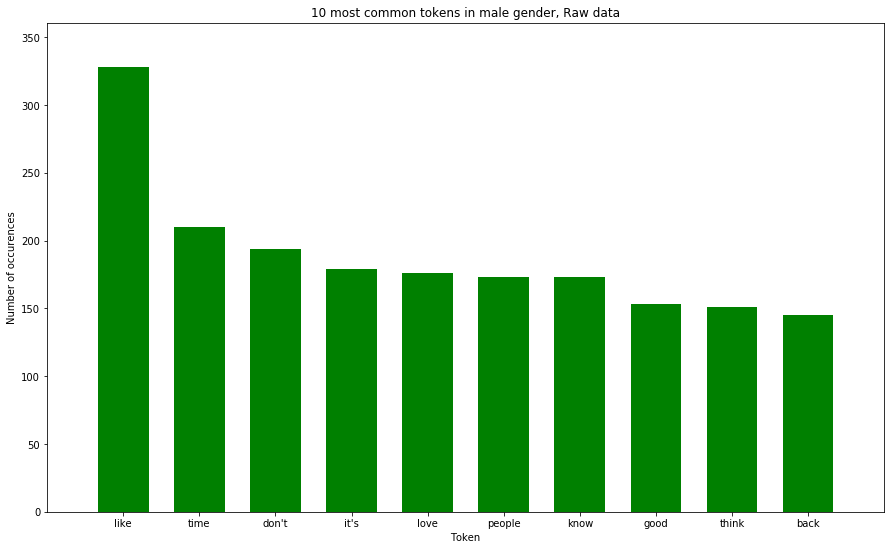

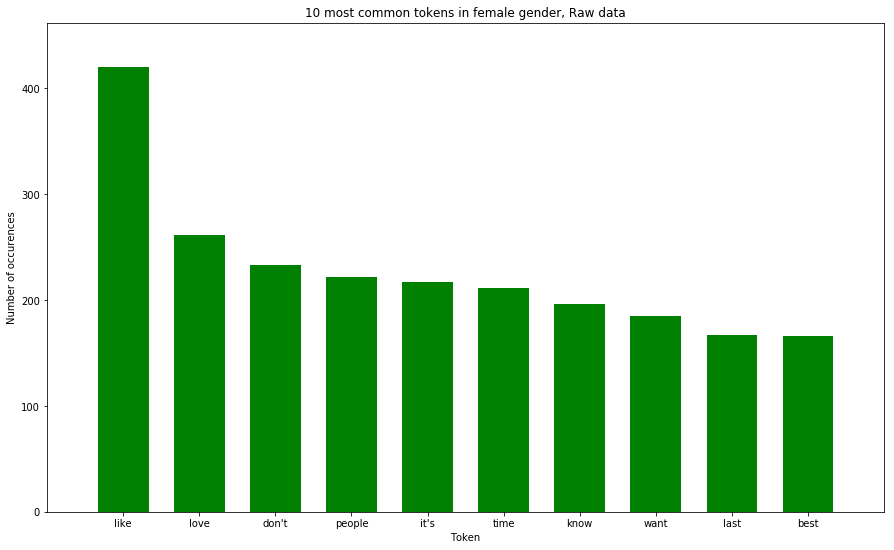

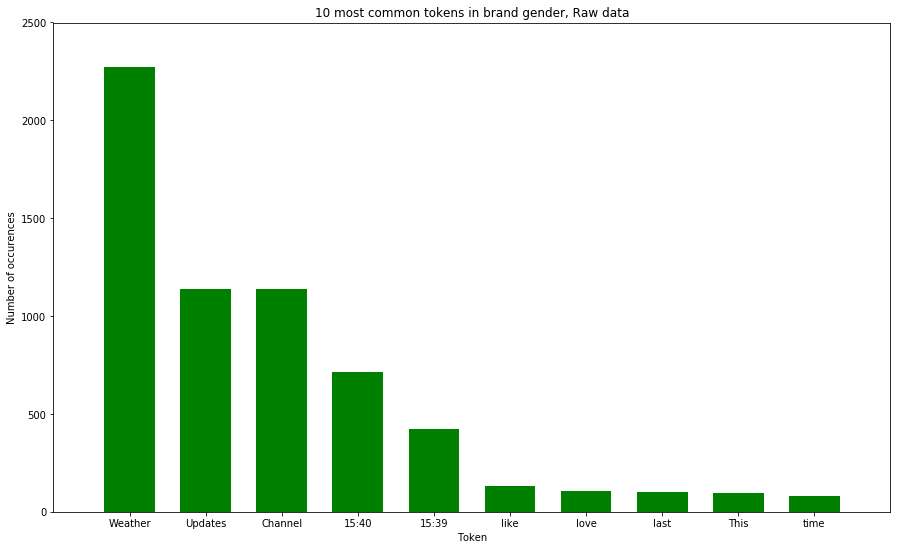

In [46]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


for gender in ['male','female','brand']:
    unzipped = list(zip(*top_10_per_gender_raw[gender]))
    xs = list(unzipped[0])
    ys = list(unzipped[1])

    plt.title('10 most common tokens in {} gender, Raw data'.format(gender))
    plt.ylabel('Number of occurences')
    plt.xlabel('Token')
    plt.axis([-1, len(xs), 0, 1.1*max(ys)])
    plt.xticks(range(len(xs)),xs)
    width = 1/1.5
    plt.bar(range(len(xs)), ys, width, color="green")

    plt.show()

As expected, the top common words in the raw data are representative of the average english language dataset (colloquial, dominated by connectors and particles.

Also, we can see the effect the spam tweets have on the data here - Weather is the number 1 most common word in the brand gender data!

Let's check out the clean data:

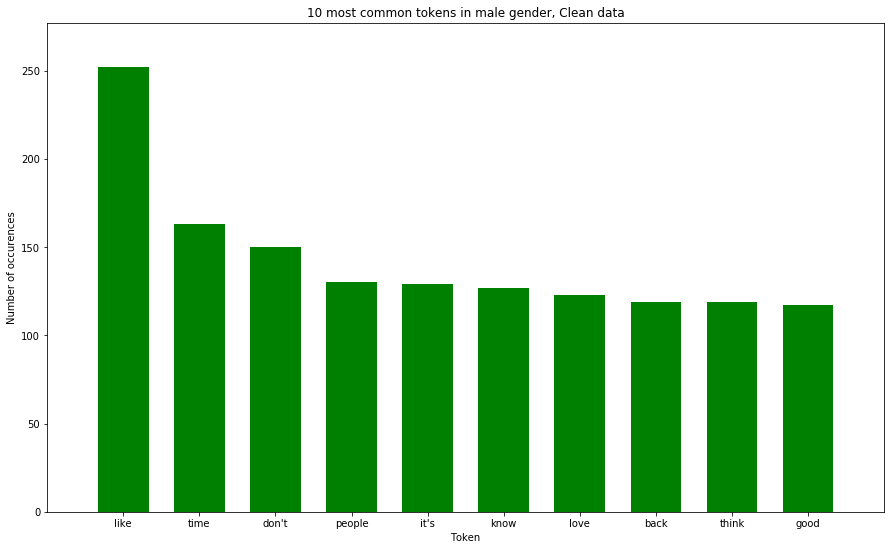

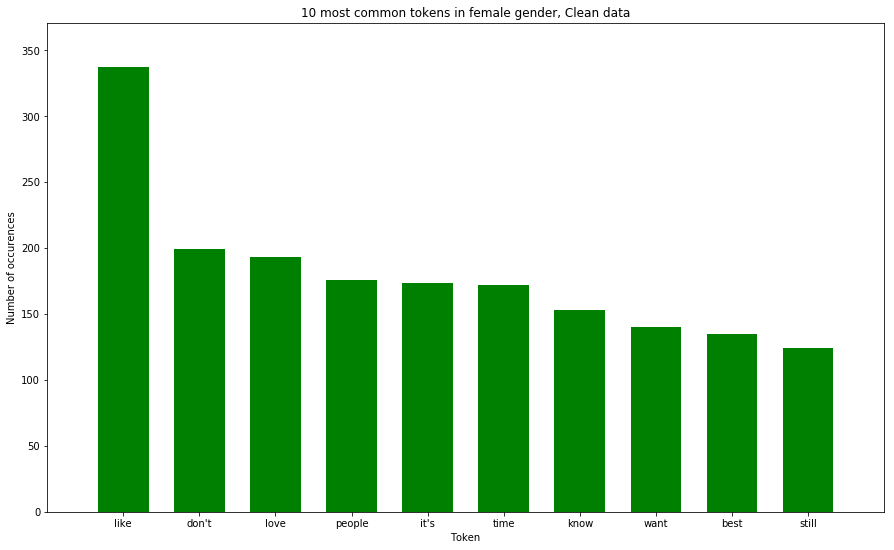

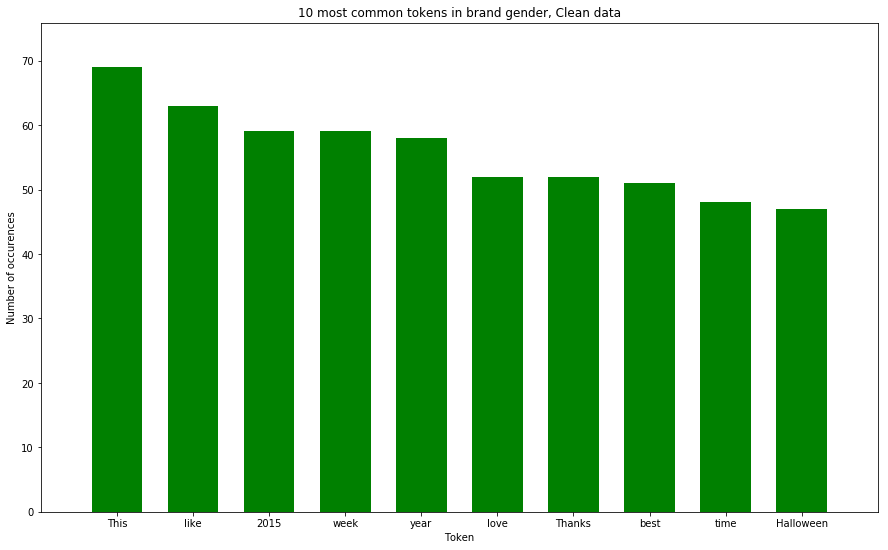

In [47]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


for gender in ['male','female','brand']:
    unzipped = list(zip(*top_10_per_gender_clean[gender]))
    xs = list(unzipped[0])
    ys = list(unzipped[1])

    plt.title('10 most common tokens in {} gender, Clean data'.format(gender))
    plt.ylabel('Number of occurences')
    plt.xlabel('Token')
    plt.axis([-1, len(xs), 0, 1.1*max(ys)])
    plt.xticks(range(len(xs)),xs)
    width = 1/1.5
    plt.bar(range(len(xs)), ys, width, color="green")

    plt.show()

__Overall:__

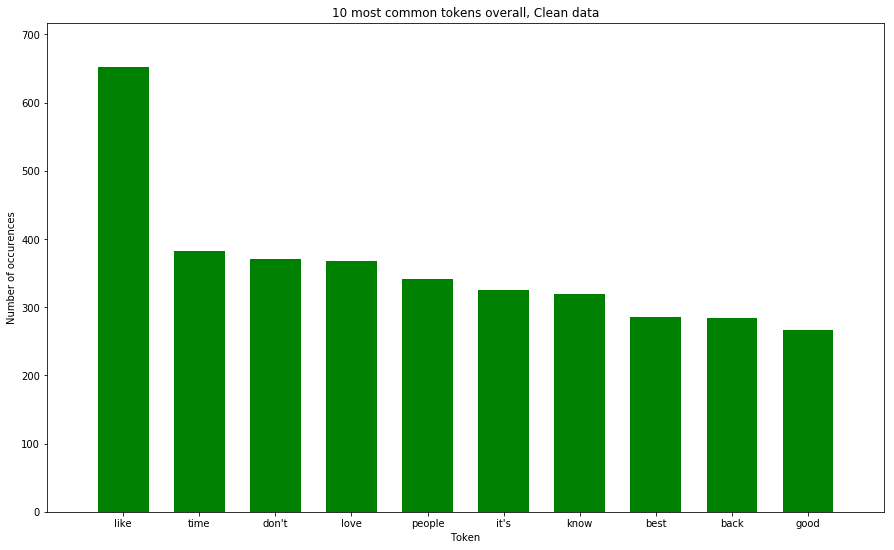

In [48]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


unzipped = list(zip(*top_10_overall))
xs = list(unzipped[0])
ys = list(unzipped[1])

plt.title('10 most common tokens overall, Clean data')
plt.ylabel('Number of occurences')
plt.xlabel('Token')
plt.axis([-1, len(xs), 0, 1.1*max(ys)])
plt.xticks(range(len(xs)),xs)
width = 1/1.5
plt.bar(range(len(xs)), ys, width, color="green")

plt.show()

#### Number of words occurring 1-10 times

This is a metric for the richness of the vocabulary used in the tweets - words that do not occur very often in the dataset are informative in classifying based on the BOW representation of the tweets.. 

Let's first restore the vocabulary counters (recover "uninteresting" words)

In [49]:
counter_vocabulary_per_gender_raw , counter_vocabulary_per_gender_clean , counter_vocabulary_overall = create_vocabulary_counters()

In [50]:
words_per_gender_raw=dict()
words_per_gender_clean=dict()
words_overall=dict()

for gender in ['male','female','brand']:
    words_per_gender_raw[gender] = {i:0 for i in range(1,11)}
    words_per_gender_clean[gender] = {i:0 for i in range(1,11)}

    
for gender in ['male','female','brand']:
    for word,count in counter_vocabulary_per_gender_raw[gender].most_common():
         if count in range(1,11):
            words_per_gender_raw[gender][count]+=1
    for word,count in counter_vocabulary_per_gender_clean[gender].most_common():
         if count in range(1,11):
            words_per_gender_clean[gender][count]+=1
             
words_overall = {i:0 for i in range(1,11)}

for word,count in counter_vocabulary_overall.most_common():
        if count in range(1,11):
            words_overall[count]+=1

__Per gender:__

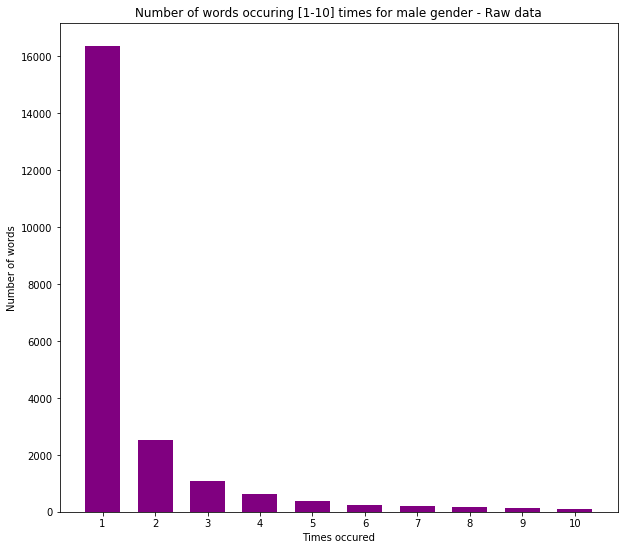

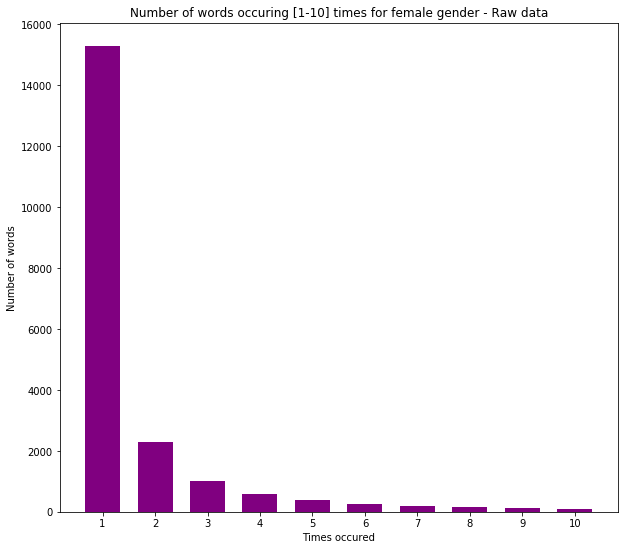

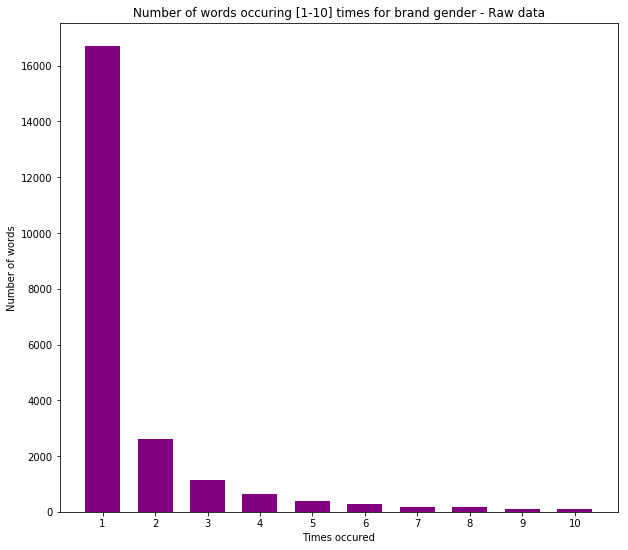

In [51]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


for gender in ['male','female','brand']: 
    xs = sorted(words_per_gender_raw[gender].keys())
    
    ys = [words_per_gender_raw[gender][occurences] for occurences in xs]
    
    
    plt.title('Number of words occuring [1-10] times for {} gender - Raw data'.format(gender))
    plt.ylabel('Number of words')
    plt.xlabel('Times occured')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="purple")

    plt.show()

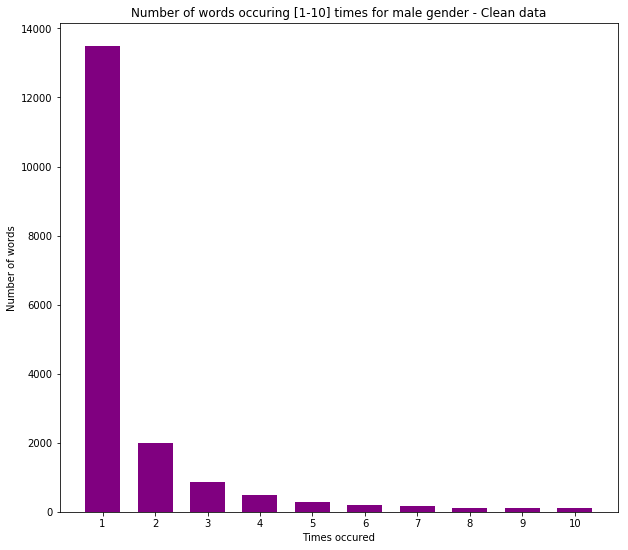

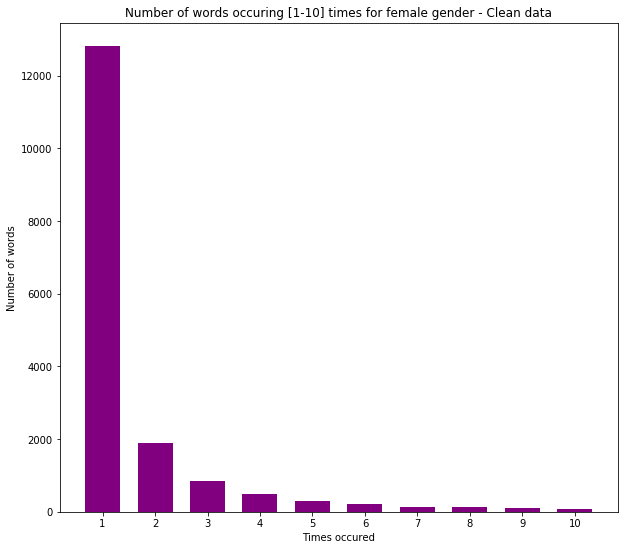

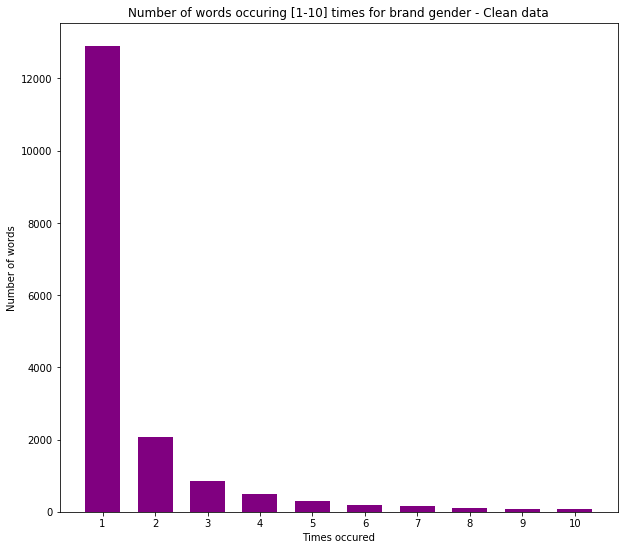

In [52]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


for gender in ['male','female','brand']: 
    xs = sorted(words_per_gender_clean[gender].keys())
    
    ys = [words_per_gender_clean[gender][occurences] for occurences in xs]
    
    
    plt.title('Number of words occuring [1-10] times for {} gender - Clean data'.format(gender))
    plt.ylabel('Number of words')
    plt.xlabel('Times occured')
    plt.xticks(range(len(xs)),xs)
    plt.bar(range(len(xs)), ys, width, color="purple")

    plt.show()

__Overall:__

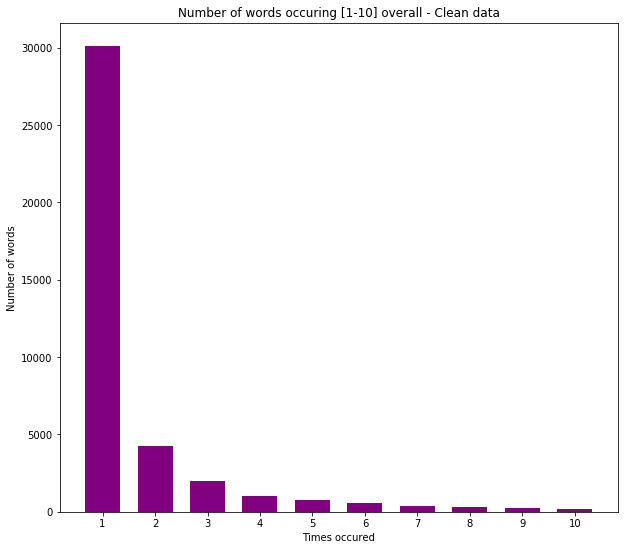

In [53]:
xs = sorted(words_overall.keys())
    
ys = [words_overall[occurences] for occurences in xs]


plt.title('Number of words occuring [1-10] overall - Clean data')
plt.ylabel('Number of words')
plt.xlabel('Times occured')
plt.xticks(range(len(xs)),xs)
plt.bar(range(len(xs)), ys, width, color="purple")

plt.show()

So lots of words occur just once throughout the entire data, this can make life difficult for us because one occurence of a word is not indicitiave of anything, really.

### Words unique to any gender

(i will only use the clean data for this exploration)

Throughout the exploration i have come across some profanity and curse words, so i grabbed a list of the most common profanities and i will use it throughout the assignment.

Let's whip up a quick profanity filter so as to censor profanities in the plots:

In [54]:
def get_profanities():
    raw = open(PROFANITIES_PATH,'r').read()
    res = []
    for line in raw.split('\n'):
        line = line.replace('\'','')
        line = line.replace(',','')
        res.append(line.strip())
    return set(res)    

In [55]:
def censor(word):
    if word in get_profanities():
        return word[0]+('*'*(len(word)-2))+word[-1]
    return word

print(censor('test-curse-word'))
print(censor('roses'))

t*************d
roses


In [56]:
uniques_per_gender = dict()
uniques_per_gender['male'] = []
uniques_per_gender['female'] = []
uniques_per_gender['brand'] = []


for word in counter_vocabulary_per_gender_clean['male'].keys():
    if word not in counter_vocabulary_per_gender_clean['female'].keys() and word not in counter_vocabulary_per_gender_clean['brand'].keys():
        uniques_per_gender['male'].append(word)
        
for word in counter_vocabulary_per_gender_clean['female'].keys():
    if word not in counter_vocabulary_per_gender_clean['male'].keys() and word not in counter_vocabulary_per_gender_clean['brand'].keys():
        uniques_per_gender['female'].append(word)        
                
for word in counter_vocabulary_per_gender_clean['brand'].keys():
    if word not in counter_vocabulary_per_gender_clean['male'].keys() and word not in counter_vocabulary_per_gender_clean['female'].keys():
        uniques_per_gender['brand'].append(word)   

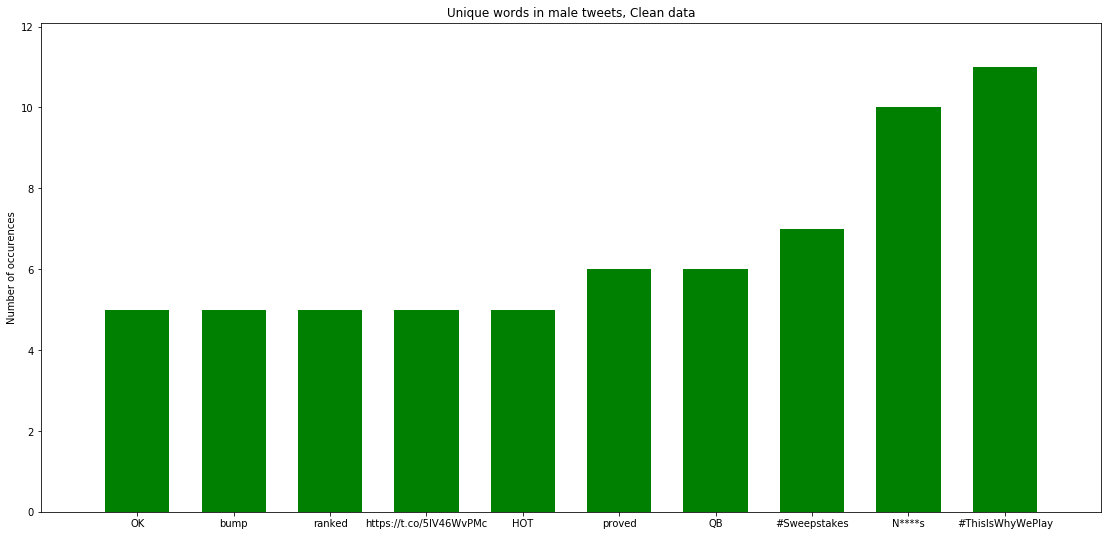

In [57]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 19
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


xs = sorted(uniques_per_gender['male'],key=lambda x : counter_vocabulary_per_gender_clean['male'][x])[-10:]

ys = list([counter_vocabulary_per_gender_clean['male'][x] for x in xs])

plt.title('Unique words in male tweets, Clean data')
plt.ylabel('Number of occurences')
plt.xlabel('')
plt.axis([-1, len(xs), 0, 1.1*max(ys)])
plt.xticks(range(len(xs)),[censor(x) for x in xs])
width = 1/1.5
plt.bar(range(len(xs)), ys, width, color="green")

plt.show()

If you are wondering where that url leads to, its here: http://thehilltalk.com/2015/09/07/former-clinton-aide-pleads-the-fifth-not-cooperating-with-investigators/

In addition, a very popular male token was (#)WhyImNotVotingForHillary, as well as lots of sports words (ball, league, players), and some profanity.

Let's move on to the females' unique words:

In [58]:
def demoji(word): 
    #some previous failed attempts:
#     emoji_pattern = u'[U00010000-U0010ffff]'
#     emoji_pattern = u'[uD800-uDBFF][uDC00-uDFFF]'
#     emoji_pattern = r'/[U0001F601-U0001F64F]/u'
#     for character in word:
#         if re.match(emoji_pattern, character):
#     if u"\u25A1" in word:
#     print(word)
    if u'_\xef' in word:
        return '*some emoji*'
    return word

print(demoji(u'_\xef\xa2\x8d\xd7\x90\xc2\xa9_\xef\xa2\x8d\xd7\x90\xc2'))


*some emoji*


[u':-(', u'advantage', u'universe', u'Ily', u'church', u"i've", u'Lottie', u'@lottietommo', u'makeup', u'#FALive']


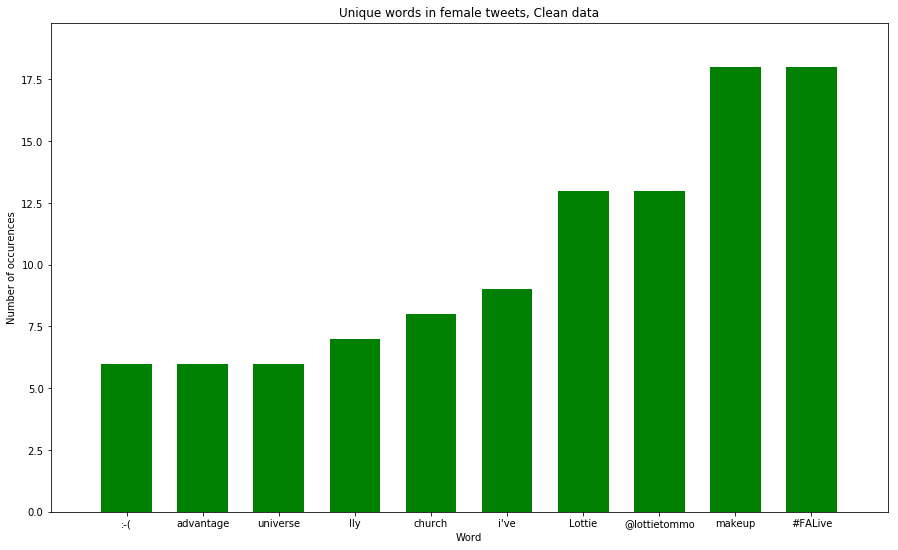

In [59]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


xs = sorted(uniques_per_gender['female'],key=lambda x : counter_vocabulary_per_gender_clean['female'][x])[-10:]
print(xs)
ys = list([counter_vocabulary_per_gender_clean['female'][x] for x in xs])


plt.title('Unique words in female tweets, Clean data')
plt.ylabel('Number of occurences')
plt.xlabel('Word')
plt.axis([-1, len(xs), 0, 1.1*max(ys)])
# plt.xticks(range(len(xs)),[censor(x) for x in xs]) encodla
plt.xticks(range(len(xs)),[demoji(censor(x)) for x in xs])
width = 1/1.5
plt.bar(range(len(xs)), ys, width, color="green")

plt.show()

Finally the brands unique words:

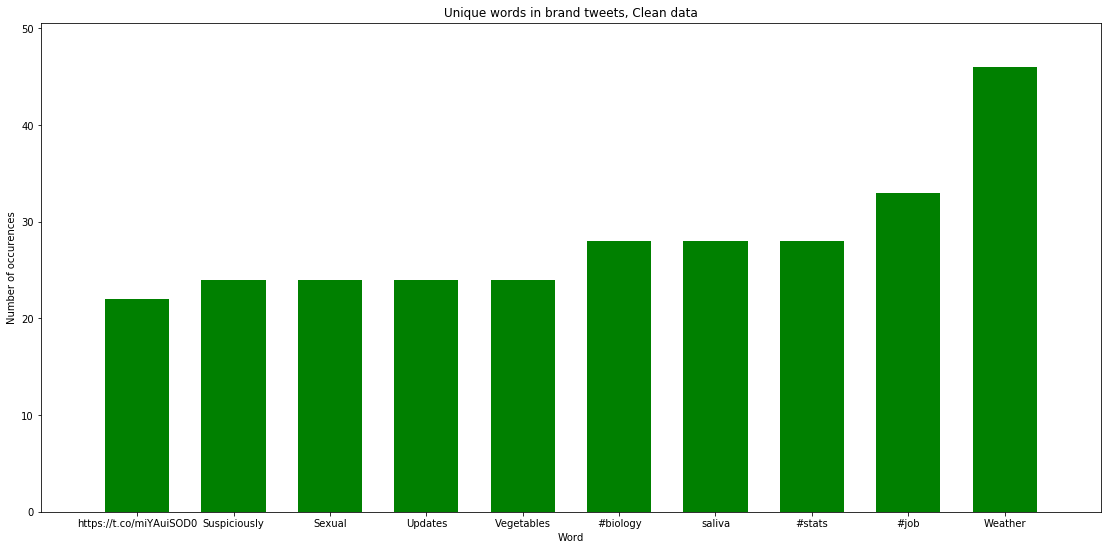

In [60]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 19
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


xs = sorted(uniques_per_gender['brand'],key=lambda x : counter_vocabulary_per_gender_clean['brand'][x])[-10:]


ys = list([counter_vocabulary_per_gender_clean['brand'][x] for x in xs])


plt.title('Unique words in brand tweets, Clean data')
plt.ylabel('Number of occurences')
plt.xlabel('Word')
plt.axis([-1, len(xs), 0, 1.1*max(ys)])
plt.xticks(range(len(xs)),[x for x in xs])
width = 1/1.5
plt.bar(range(len(xs)), ys, width, color="green")

plt.show()

So we have a few upper-case (probably marketing related) terms, some remnants of the removed spam (Weather), and some advertisement links.

A quick couple of conclusions from data exploration:

So there are obviously a plethora of links (http, https) thrown around in twitter, _especially_ by brands - it can not bee seen in the graphs above because i am using a tokenizer that chunks URLs into a single token.

(brands used https about 3100 times throughout, while males and females hover around 1500-1600 http tokens.)

In addition, the data is full of special characters (emojis, #s, @s) and words (words with typos, words with elongated tails such as "happyyyy", made up words). 

I will try to have our features help us navigate through this "rough terrain".

## Question 2

### Feature Extraction

I intend to extract count-based features (Tdfif with n-grams), and a great number of lexical/morphological features. I will first write (many) methods to help with extracting said features, then extract them.

__The features to be extracted are:__

From the tweet text:
    1.  How many words that end with 3 of the same character does the tweet have? (sooo, happyyy, etc.)
    2.  How many profanities does the text contain? (uses profanities.txt for reference)
    3.  How many slang words does the text contain? (uses UrbanDictionary's API)
    4.  How mony emoji tokens does the text contain? (uses a regex that captures emojis)
    5.  How many negatively charged smilies does the text contain? ( e.g :( )
    6.  How many positively charged smilies does the text contain? ( e.g :) )
    7.  How many words of length <4 does the text contain?
    8.  How many function words does the text contain?
    9.  How many content words does the text contain?
    10. What is the sentiment score of the text? (-1 to 1)
    11. How many words are there, which are negatively charged
    12. How many words are there, which are positively charged (sentimentally)
    13. How many alphabetic characters are there in the text?
    14. How many punctuation symbols are there in the text?
    15. How many upper case characters does the text contain?
    16. How many digit characters does the text contain?
    17. How many spaces (\s) does the text contain?
    18. How many special characters does the text contain?
    19. How many tokens are there in the text?
    20. How many characters are there in the text?
    21. How many words appeared once in the tweet? (hapax legomena)
    22. How many words appeared twice in the tweet? (dis legomena)
    23. What is the average lenghth of words in the text?
    24. How many words in the text are unique in the dataset?
    25. How many sentences does the text contain?
    26. How many verbs are there in the text?
    27. How many types (distinct words) are there in the text?
    
    
    28. The average embedding over all words in the text (will be explained below)
    
    Non-text features:
    29. the link_color and sidebar_color of the user who posted the tweet (this is attached in dataset)
    
    Count-based features:
    30. 1-5 character grams on the user's nickname
    31. 1-5 character grams on the user's description
    32. 1-5 character grams on the tweet
    33. 1-2 word grams on the tweet+description , with Tdf-if.
    

In [61]:
#this is a very general method, aimed at calculating the amount of words/chars agree a given condition in a given tweet
def number_of(tokens,predicate):
    count = 0
        
    for token in tokens:  
        if predicate(token):
            count+=1
            
    return count    

In [62]:
def has_repeated_last_letter(word):
    return len(word)>=4 and word[-1] == word[-2] and word[-2] == word[-3]

has_repeated_last_letter('happyyy')

True

In [63]:
number_of(tokenizer.tokenize('sooo happyyy right now'),has_repeated_last_letter)

2

In [64]:
def is_profanity(word):
    return censor(word) != word

is_profanity('test-curse-word')

True

In [65]:
number_of(tokenizer.tokenize('test-curse-word, i can\'t believe that final possession'),is_profanity)

1

In [66]:
def is_emoji(word):
    return demoji(word) != word

contains_emojis = [text for text in clean_df['text'] if len([word for word in tokenizer.tokenize(text) if is_emoji(word)])>0]
contains_emojis[0].split()

for word in contains_emojis[0].split():
    print('Word: {} is_emoji: {}'.format(word.encode('utf8'),is_emoji(word)))

Word: Watching is_emoji: False
Word: Neighbours is_emoji: False
Word: on is_emoji: False
Word: Sky+ is_emoji: False
Word: catching is_emoji: False
Word: up is_emoji: False
Word: with is_emoji: False
Word: the is_emoji: False
Word: Neighbs!! is_emoji: False
Word: Xxx is_emoji: False
Word: _ï¢×§Ö´_ï¢×§Ö´_ï¢×§Ö´_ï¢×°Ö¾_ï¢ÂÖ¸_ï¢×°Â_ï¢ÂÖ¸ is_emoji: True
Word: Xxx is_emoji: False


In [67]:
def remove_emojis(text):
    tokens = text.split()
    res = []
    for token in tokens:
        if not is_emoji(token):
            res.append(token)
    return ' '.join(res)   

The following few lines of code is an impromptu DIY slang detector, it is not very accurate (practically no false positives, but plenty of false negatives), but it works. 

Problem is, Urbandictionary's API limits HTTP requests and i could'nt even check a quarter of all tokens in the dataset vocabulary. So i will not extract a feature from this, but i'll leave it here as a souvenir 

In [68]:
english_dictionary = dict.fromkeys(nltk_words.words(), None)

#this method checks if a word is in nltk's definition of the english vocabulary. this is a problem when dealing with
#words that DO exist in english, but are definitely used as slang, such as "gnarly" and "rad"
def is_english_word(word):
    try:
        x = english_dictionary[word]
        return True
    except KeyError:
        return False

def is_slang_abbr(word):
    if is_english_word(word) or len(word)<=2 or is_emoji(word) or u'\xe2' in word:
        return False #this will spare us from overquerying urbandictionary's api.
    base = 'http://api.urbandictionary.com/v0/define?term='
    try:
        response = urllib2.urlopen(base+word)
    except UnicodeEncodeError:
        print(word)
        return False
    
    data = json.loads(response.read())

    if data['result_type'] != 'exact':
        return False

    slang_tags = {'abbrev','slang','acronym'}
    definitions = list([definition for definition in data['list']])[:5]
    
    for defi in definitions:
        if defi['thumbs_up']>=2*defi['thumbs_down']:
            for term in slang_tags:
                if term in defi['definition'].lower():
                    return True

    return False

slangs = dict()

is_slang_abbr('wth')#=what the hell

True

In [69]:
is_slang_abbr('smdh')#=shaking my damn head

True

In [70]:
number_of(tokenizer.tokenize('omg!!! that ride was so bonkers :O :O '),is_slang_abbr)

2

In [71]:
number_of(contains_emojis[0].split(),is_emoji)

1

In [72]:
POSITIVE_SMILIES = ["*O", "*-*", "*O*", "*o*", "* *",
                ":P", ":D", ":d", ":p",
                ";P", ";D", ";d", ";p",
                ":-)", ";-)", ":=)", ";=)",
                ":<)", ":>)", ";>)", ";=)",
                "=}","=]","[=", ":)", "(:;)",
                "(;", ":}", "{:", ";}",
                "{;:]",'=)','(='
                "[;", ":')", ";')", ":-3",
                "{;", ":]",
                ";-3", ":-x", ";-x", ":-X",
                ";-X", ":-}", ";-=}", ":-]",
                ";-]", ":-.)","[:", ";]"
                "^_^", "^-^",'<3','P:','D:']
NEGATIVE_SMILIES = [":(", ";(", ":'(",'=(',')='
                "=(", "={","=[","]=", "):", ");",
                ")':", ")';", ")=", "}=",
                ";-{{", ";-{", ":-{{", ":-{",
                ":-(", ";-(",':<','>:','=,(', ":,)", ":'{"
                ]

It was very difficult finding/building a good regular expression that captures all smilies, so i hard coded them.

In [73]:
def num_of_negative_smilies(tweet):
    count=0
    for neg in NEGATIVE_SMILIES:
        if neg in tweet:
            count+=1 
    return count

num_of_negative_smilies('couldn\'t make the train today :(. had to take a cab =,(')  

2

In [74]:
def num_of_positive_smilies(tweet):
    count=0
    for neg in POSITIVE_SMILIES:
        if neg in tweet:
            count+=1 
    return count

num_of_positive_smilies('made the train today :))). Didn\'t have to take a cab =)')  

2

In [75]:
def is_shorter_than_4(word):
    return len(word)<4

is_shorter_than_4('never')

False

In [76]:
def is_function_word(word):
    return word.lower() in stop

is_function_word('To')

True

In [77]:
def is_content_word(word):
    return word.lower() not in stop

is_content_word('Alaska')

True

In [78]:
def sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

sentiment_polarity('i keep forgetting how awful Mondays are')

-1.0

In [79]:
def is_negative_sentiment(word):
    return TextBlob(word).sentiment.polarity<=-0.2

is_negative_sentiment('terrible')

True

In [80]:
def is_positive_sentiment(word):
    return TextBlob(word).sentiment.polarity>=0.2

is_positive_sentiment('great')

True

In [81]:
def is_alphabetic(char):
    return char.isalpha()

print(is_alphabetic('%'))

False


In [82]:
def punct_in_word(word):
    num = 0
    for char in word:
        if char not in string.punctuation:
            return 0
        num+=1
    return num

punct_in_word('..')

2

In [83]:
def num_of_punct(tokens):
    return sum([punct_in_word(token) for token in tokens])

num_of_punct(tokenizer.tokenize('are you: 1) bored 2) angry?'))

4

In [84]:
def is_question_mark(word):
    return word == '?'

is_question_mark('?')

True

In [85]:
def question_marks_over_all_puncatuation(tokens):
    punct = num_of_punct(tokens)
    if punct == 0:
        return 0
    num_of_question_marks = number_of(tokens,is_question_mark)
    return float(num_of_question_marks) / punct 

question_marks_over_all_puncatuation('uhm... can i just ask what you guys are doing?')

0.25

In [86]:
def is_upper(char):
    return char.isupper()

is_upper('r')

False

In [87]:
def is_digit(char):
    return char.isdigit()

is_digit('9')

True

In [88]:
def is_space(char):
    return char == ' '

is_space('9')

False

In [89]:
special_chars = ["$", "%", "&", "*",
"~", "^", "-", "=", "+", ">",
"<", "[", "]", "{", "}", "|", "\"", "/"]

In [90]:
def is_special(char):
    return char in special_chars

is_special('&')

True

In [91]:
#=words that appeared once in the tweet
def num_of_hapax_legomena(tokens):
    occurences = Counter(tokens)
    return len(list([key for key in occurences.keys() if occurences[key]==1]))

num_of_hapax_legomena(['i','think','you','think'])

2

In [92]:
#=words that appeared twice in the tweet
def num_of_dis_legomena(tokens):
    occurences = Counter(tokens)
    return len(list([key for key in occurences.keys() if occurences[key]==2]))

num_of_dis_legomena(['i','think','you','think'])

1

In [93]:
def average_word_length(tokens):
    lengths = [len(token) for token in tokens]
    return sum(lengths)/float(len(lengths))

average_word_length(['i','think','you','ranch'])

3.5

In [94]:
def unique_words(tokens):
    return len(list([token for token in tokens if counter_vocabulary_overall[token] == 1]))
    
unique_words(['as','i','was','saying',',','critics'])

1

In [95]:
def num_of_verbs(pos_tags):
    verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']
    return len(list([tag for tag in pos_tags if tag in verb_tags]))
 
num_of_verbs(['VB','NN','ADVB'])

1

In [96]:
def num_of_types(tokens):
    return len(Counter(tokens))

num_of_types(['i','walked','right','past','her'])

5

I will now set up our word embeddings model (using gensim and Google's trained word2vec model)

It can be downloaded from here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [97]:
MODEL_PATH = "GoogleNews-vectors-negative300.bin"
w = models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True)
print (w["queen"].shape)

(300L,)


In [98]:
EMBEDDING_SHAPE = int(w["queen"].shape[0])

EMBEDDING_SHAPE

300

This is the gist of the word embeddings' value as features:

In [99]:
stringA = 'woman'
stringB = 'king'
stringC = 'man'
print(w.most_similar(positive=[stringA, stringB], negative=[stringC], topn=10))

[(u'queen', 0.7118192911148071), (u'monarch', 0.6189674139022827), (u'princess', 0.5902431011199951), (u'crown_prince', 0.5499460697174072), (u'prince', 0.5377321243286133), (u'kings', 0.5236844420433044), (u'Queen_Consort', 0.5235945582389832), (u'queens', 0.518113374710083), (u'sultan', 0.5098593235015869), (u'monarchy', 0.5087411999702454)]


The features that i will extract here is the average over all word embeddings in a given tweet. So we expect to have just another 300 features per tweet.

The reason an average over all the embeddings makes sense as a feature is, that word embeddings capture distance between words, basically turning the vocabulary into an n-dimensional space (in our case, 300 dimensional) with all points (words) in that space having a meaningful distance for all other points. So in a way, the average over all word embeddings in a tweet is the "average" over the meaning of the tweet.

This can be also described as a normalized Bag-of-embeddings feature.

In [100]:
#convert an embedding to the form {'embedding1' : 0.152327...., 'embedding2' : -0.32562316... , etc}
def convert_embedding_to_dict(embedding):
    res = dict()      
    j=0
    for value in embedding:
        j+=1
        res.update({'embedding{}'.format(j) : value})
    return res    

In [101]:
#given a list of words, get the average embedding of all those words. returns a list of dimension EMBEDDING_SHAPE.
def get_average_embedding(tokens):
    word_embeddings = []
    for token in tokens:
        if token in w.vocab:
              word_embeddings.append(w[token])
        #otherwise, no embedding to consider for this token - do nothing 
    
    sum_of_embeddings = list([0 for i in range(EMBEDDING_SHAPE)])#initialize sums
    for embedding in word_embeddings:
        j=0
        for value in embedding:
            sum_of_embeddings[j]+=value
            j+=1
    divisor = max(1,len(word_embeddings))        
    return list([value/divisor for value in sum_of_embeddings])#averaging


In [102]:
#given a list of words, get the dictionary form of theier average embedding
def get_embedding(tokens):
    average_embedding = get_average_embedding(tokens)
    return convert_embedding_to_dict(average_embedding)

In [103]:
#for example,

get_embedding(['this','is','a','tweet'])

{'embedding1': 0.06322224934895833,
 'embedding10': -0.031453450520833336,
 'embedding100': 0.09138997395833333,
 'embedding101': -0.069091796875,
 'embedding102': -0.008992513020833334,
 'embedding103': -0.0823974609375,
 'embedding104': -0.021321614583333332,
 'embedding105': -0.10091145833333333,
 'embedding106': -0.030924479166666668,
 'embedding107': -0.14017740885416666,
 'embedding108': -0.17350260416666666,
 'embedding109': -0.028483072916666668,
 'embedding11': -0.10660807291666667,
 'embedding110': -0.028971354166666668,
 'embedding111': -0.12443033854166667,
 'embedding112': -0.07082112630208333,
 'embedding113': -0.0440673828125,
 'embedding114': 0.005126953125,
 'embedding115': 0.120849609375,
 'embedding116': -0.039754231770833336,
 'embedding117': 0.10611979166666667,
 'embedding118': -0.11100260416666667,
 'embedding119': 0.21744791666666666,
 'embedding12': -0.09834798177083333,
 'embedding120': 0.10074869791666667,
 'embedding121': -0.010823567708333334,
 'embedding12

In [104]:
#and another test (not very coherent, but it proves correctness of our procedure)
get_embedding(['queen','king'])['embedding1'] == (w['queen'][0] + w['king'][0])/2  


True

Word embeddings can capture semantic similarities between words

In [105]:
# #todo search for whoopsies from copying: questions labels categor 
 
# v df['link_color'], df['sidebar_color'] 
 
 
# v append desc / in seperate

# v char ngrams 5
# v word ngrams 2
# v nickname 1-5 char ngrams
 
# #classifiers:
# v multinomialNB
# v logisticregression
# v perceptron
# mlp
# svm
# random forest

In [113]:
#gets a tweet(text,desc,nickname,link_color,sidebar_color)
#tweet = [text,desc,nickname,link_color,sidebar_color,gender]
def features(tweet):
    text = tweet[0]
    #text = 
    desc = tweet[1]
    nickname = tweet[2]
    link_color = tweet[3]
    sidebar_color = tweet[4]
    
    #Text based features:
    tokenized = tokenizer.tokenize(text)
    pos_tags = nltk.pos_tag(tokenized)
    features = {}
    features = {'emojis' : number_of(text.split(),is_emoji)}    
        
    text = remove_emojis(text) 
    
    features.update({
        'repeated_letters' : number_of(tokenized,has_repeated_last_letter),
        'profanities' : number_of(tokenized,is_profanity),
        'negative_smilies' : num_of_negative_smilies(remove_url(text)),
        'positive_smilies' : num_of_positive_smilies(remove_url(text)), 

        'sentiment_polarity' : sentiment_polarity(text),
        'negative_words' : number_of(tokenized,is_negative_sentiment),
        'positive_words' : number_of(tokenized,is_positive_sentiment),
        'punctuation' : num_of_punct(tokenized),
#         'question_marks_over_all_punctuation' : question_marks_over_all_puncatuation(tokenized),
#         'alphabetic_characters' : number_of(remove_url(text),is_alphabetic)/float(len(remove_url(text))+1),#normalized
#         'spaces' : number_of(text,is_space)/float(len(text)+1),
#         'number_of_tokens' : len(tokenized),
#         'number_of_characters' : len(text),
#         'hapax_legomena' : num_of_hapax_legomena(tokenized) / float(len(tokenized)),
#         'dis_legomena' : num_of_dis_legomena(tokenized) / float(len(tokenized)),
#         'average_word_length' : average_word_length(tokenized) ,
#         'unique_words_in_dataset' : unique_words(tokenized) ,
#         'shorter_than_4' : number_of(text.split(),is_shorter_than_4)/float(len(text.split())+1),#normalized
#         'function_words' : number_of(tokenized,is_function_word)/float(len(tokenized)),
#         'content_words' : number_of(tokenized,is_content_word)/float(len(tokenized)),
#         'upper_cases' : number_of(remove_url(text),is_upper)/float(number_of(remove_url(text),is_alphabetic)+1),
#         'digits' : number_of(remove_url(text),is_digit)/float(len(remove_url(text))+1), 
#         'sentences' : len(nltk.sent_tokenize(remove_url(text))) , 

     'specials' : number_of(remove_url(text),is_special)/float(len(remove_url(text))+1),
     'verbs' : num_of_verbs(pos_tags),
     'types' : num_of_types(tokenized), 
        
       
    })
    
    features.update(get_embedding(tokenized))
  
    #non text-based features:
    features.update({'link_color' : link_color})
    features.update({'sidebar_color' : sidebar_color})

                
    return features

In [116]:
# for example:

features(('I could not believe it!! #XFactorFinals was amazing to behold, can\'t get over it :O :O','whatever','johnlancer443','',''))

{'embedding1': 0.019400460379464284,
 'embedding10': 0.13528878348214285,
 'embedding100': 0.021963936941964284,
 'embedding101': -0.07852608816964286,
 'embedding102': -0.025691441127232144,
 'embedding103': 0.0198974609375,
 'embedding104': 0.020403180803571428,
 'embedding105': -0.07289341517857142,
 'embedding106': -2.288818359375e-05,
 'embedding107': -0.06841169084821429,
 'embedding108': -0.08712332589285714,
 'embedding109': 0.011553083147321428,
 'embedding11': -0.07898330688476562,
 'embedding110': -0.04356602260044643,
 'embedding111': -0.06941005161830358,
 'embedding112': 0.016845703125,
 'embedding113': -0.022173200334821428,
 'embedding114': -0.02099609375,
 'embedding115': 0.107421875,
 'embedding116': 0.03550175258091518,
 'embedding117': 0.04441179547991071,
 'embedding118': -0.03604214532034738,
 'embedding119': 0.03373908996582031,
 'embedding12': -0.1702880859375,
 'embedding120': -0.00970458984375,
 'embedding121': -0.06223406110491071,
 'embedding122': -0.0301949

In [114]:
#this extracts features from a dataframe
class MyFeaturesExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def transform(self, df, y=None):        
        data = list(zip(df['text_desc'],df['description'],df['name'],df['link_color'],df['sidebar_color']))
        return [features(tweet) for tweet in data]

    def fit(self, df, y=None):
        return self

In [109]:
#this is so we can comfortably use all columns in our dataset (nickname,description, etc)
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return data[self.key]

In [115]:
pipeline = Pipeline([
    
    ('union', FeatureUnion(
        transformer_list=[
            ('text tdfif', Pipeline([
                ('selector', ItemSelector(key='text_desc')),
                ('tfidf', TfidfVectorizer(tokenizer=tokenizer.tokenize,ngram_range=(1,2),min_df=2,sublinear_tf=True)),
            ])),
            
             ('name char ngrams', Pipeline([
                ('selector', ItemSelector(key='name')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),
            
            ('desc char ngrams', Pipeline([
                ('selector', ItemSelector(key='description')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),
            
             ('text char ngrams', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),

            ('my_features', Pipeline([
                ('features', MyFeaturesExtractor()), #returns a dictionary
                ('dict',DictVectorizer())
            ])),
        ],
    )),

#     ('perceptron', Perceptron()),
#     ('mlp',MLPClassifier(shuffle=True,verbose=True))
    ('logistic',LogisticRegression(multi_class='multinomial',solver='sag',max_iter = 150))
#      ('logistic',LogisticRegression(multi_class='multinomial',solver='newton-cg'))

#      ('bayes',MultinomialNB())
])
pipeline.fit(clean_df[:int(0.9*len(clean_df))], clean_df['gender'][:int(0.9*len(clean_df))])
pred = pipeline.predict(clean_df[int(0.9*len(clean_df)):])
print(classification_report(clean_df['gender'][int(0.9*len(clean_df)):], pred))
print('Accuracy score: {}'.format(accuracy_score(clean_df['gender'][int(0.9*len(clean_df)):], pred)))

#0.56 without embeddings
#0.585 with
#0.63 with subset1
#0.6302 with subset2
#0.627 subset3
#0.632 best
#0.734 with full pipeline, default clean, 90-10 split, max_iter = 150 ,sublinear tf
#newton-cg - 

             precision    recall  f1-score   support

      brand       0.78      0.79      0.79       273
     female       0.76      0.77      0.77       619
       male       0.66      0.64      0.65       425

avg / total       0.73      0.73      0.73      1317

Accuracy score: 0.733485193622


Let's build our Keras based deep learning model:

In [110]:
import keras
import keras.preprocessing.text as kpt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#same split as with the above model
x_train = clean_df['text_desc'][:int(0.9*len(clean_df))]

gender_to_int = {'female':0,'male':1,'brand':2}

y_train = list([gender_to_int[gender] for gender in clean_df['gender'][:int(0.9*len(clean_df))]]) 
y_train = keras.utils.to_categorical(y_train, 3)


I would like to use Keras' method to turn a sequence of indices into out vocabulary dictionary, into a one-hot encoding of that sequence. However i do not want to use Keras' tokenizer, so i will tokenize with TweetTokenizer, then feed it to Keras' tokenizer and hopefully, it does not ruin the previous tokenization.

In [111]:
N_WORDS = 10000

keras_tokenizer = kpt.Tokenizer(filters='', lower=True,split = ' ',num_words=N_WORDS)#configuring the keras tokenizer to do close to nothing in terms of tokenization

texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_train]) 

keras_tokenizer.fit_on_texts(texts_for_keras_tokenizer)

x_train = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')


model = Sequential()#initialize the NN

#add a layer that gets N_WORDS inputs (this is the BOW representation of any tweet) and outputs 512 values ()
model.add(Dense(512, input_shape=(N_WORDS,), activation='relu'))

model.add(Dropout(0.5))


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(3, activation='softmax'))# this gives a distribution over all 3 genders (probability of the input's belonging to any of the gender)
model.compile(loss='categorical_crossentropy',  optimizer='adam',  metrics=['accuracy']) 
# model.compile(loss='categorical_crossentropy',  optimizer='rmsprop',  metrics=['accuracy'])

#we are using the x,y we constructed earlier,
model.fit(x_train, y_train,  batch_size=32,  epochs=10,  verbose=1,  validation_split=0.1,  shuffle=True)



now that we have a model trained, lets predict the test data (training was done on another environment - i will attach results):

In [112]:
x_test = clean_df['text_desc'][int(0.9*len(clean_df)):]

y_test = list([gender_to_int[gender] for gender in clean_df['gender'][int(0.9*len(clean_df)):]]) 

texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_test]) 


x_test = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')

keras_pred = model.predict(x_test)

In [ ]:
int_to_gender = {0: 'female',1:'male',2:'brand'}

actual_pred = list([np.argmax(values) for values in keras_pred])# get the highest probability category for each prediction

print(classification_report(y_test, actual_pred))
print('Accuracy score: {}'.format(accuracy_score(y_test, actual_pred)))

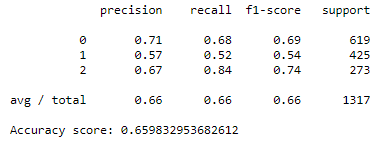

As we can see, the keras DL model didn't do as well as the "hand picked features" model did (see above).

It did score high in recall for the brands gender, probably because due to the strong differentiator between the brand tweets and the human tweets - overuse of capital letters and high sentiment polarity words.

I will now try some interesting preprocessing combinations on the following three models:

1. Just count-based features with logistic regression (our baseline model)

2. Count based + text based features with logistic regression

3. Keras DL model

In [116]:
#this returns a list of tuples, which each contain a clean training set, a clean test set, and a tag to indicate how the cleaning was done.
#the tag is a permutation over all possible parameter assignments that comprise that particular cleaning process,
#(example for a tag - should_lower=True, should_stem=False,should_remove_stop_words=True,
#should_remove_punctuation=False, should_remove_urls=False,should_remove_hashtags = True,should_remove_ats = False)
def preprocessing_combinations(df_training, df_test):
    #this produces a list of tuples which are all the possible arrangements of True,False among the cleaning steps we will use
    parameter_possibilities = list(itertools.product([0, 1], repeat=7))
    
    lower_possibility_index = 0
    stem_possibility_index = 1
    remove_stop_words_possibility_index = 2
    remove_url_possibility_index = 3
    remove_punctuation_possibility_index = 4
    remove_hashtags_possibility_index = 5
    remove_ats_possibility_index = 6

    #this will be a list of tuples.
    res = []
    
    for possibility in parameter_possibilities:
        is_lower = bool(possibility[lower_possibility_index])
        is_stemming = bool(possibility[stem_possibility_index])
        is_remove_stop_words = bool(possibility[remove_stop_words_possibility_index])
        is_remove_url = bool(possibility[remove_url_possibility_index])
        is_remove_punctuation = bool(possibility[remove_punctuation_possibility_index])
        is_remove_hashtags = bool(possibility[remove_hashtags_possibility_index])
        is_remove_hashtags = 'only_symbol' if is_remove_hashtags else 'none'
        is_remove_ats = bool(possibility[remove_ats_possibility_index])
        is_remove_ats = 'entire_expression' if is_remove_ats else 'none'

        
        current_training  = preprocess(df_training, 
                                       should_lower=is_lower,
                                       should_stem=is_stemming,
                                       should_remove_stop_words=is_remove_stop_words,
                                       should_remove_url=is_remove_url,
                                       should_remove_punctuation=is_remove_punctuation,
                                       should_remove_hashtags = is_remove_hashtags,
                                       should_remove_ats = is_remove_ats)
        current_test  = preprocess(df_test, 
                                       should_lower=is_lower,
                                       should_stem=is_stemming,
                                       should_remove_stop_words=is_remove_stop_words,
                                       should_remove_url=is_remove_url,
                                       should_remove_punctuation=is_remove_punctuation,
                                       should_remove_hashtags = is_remove_hashtags,
                                       should_remove_ats = is_remove_ats)

        current_tag= '\nlower : ' + str(is_lower)
        current_tag+= '\nstemming : ' + str(is_stemming)
        current_tag+= '\nremove stop words : '+str(is_remove_stop_words)
        current_tag+= '\nremove urls : '+str(is_remove_url)
        current_tag+= '\nremove punctuation : '+str(is_remove_punctuation)
        current_tag+= '\nremove hashtags : '+str(is_remove_hashtags)
        current_tag+= '\nremove ats : '+str(is_remove_ats)

        tagged_clean_dataset = (current_training , current_test , current_tag)
        
        res.append(tagged_clean_dataset)
    
    return res



In [117]:
training_df = clean_df[:int(0.9*len(clean_df))]#note that the df we use here was cleaned only from spam and irrelevant records. we will now clean it further
test_df = clean_df[int(0.9*len(clean_df)):]

combinations = preprocessing_combinations(training_df,test_df)

Let's try out the baseline model:

In [118]:
baseline = Pipeline([
    
    ('union', FeatureUnion(
        transformer_list=[
            ('text tdfif', Pipeline([
                ('selector', ItemSelector(key='text_desc')),
                ('tfidf', TfidfVectorizer(tokenizer=tokenizer.tokenize,ngram_range=(1,2),min_df=2,sublinear_tf=True)),
            ])),
            
             ('name char ngrams', Pipeline([
                ('selector', ItemSelector(key='name')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),
            
            ('desc char ngrams', Pipeline([
                ('selector', ItemSelector(key='description')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),
            
             ('text char ngrams', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('ngrams', CountVectorizer(analyzer='char',ngram_range=(1,5))),
            ])),
        ],
    )),

#     ('perceptron', Perceptron()),
#     ('mlp',MLPClassifier(shuffle=True,verbose=True))
    ('logistic',LogisticRegression(multi_class='multinomial',solver='sag',max_iter = 150))
#      ('logistic',LogisticRegression(multi_class='multinomial',solver='newton-cg'))
#      ('bayes',MultinomialNB())
])

In [119]:
i=0
baseline_exact_accuracies = []
baseline_precisions = []
baseline_recalls = []
baseline_f_measures = []
for combination in combinations:
    x_train = combination[0]
    y_train = combination[0]['gender']
    x_test = combination[1]
    y_test = combination[1]['gender']
    tag = combination[2]
    
    print('Training with combination number '+str(i)+'/'+str(len(combinations)))
    
    
    details = '\n\nPreprocessing parameters:\n'+tag
    

    t0 = time()
    baseline.fit(x_train,y_train)
    train_time = time() - t0
    details+="\nFeature extraction + training time: %0.3fs" % train_time
    
    t0 = time()
    pred = baseline.predict(x_test)
    test_time = time() - t0
    details+="\nTest time:  %0.3fs" % test_time

    exact_accuracy = metrics.accuracy_score(y_test, pred)
    details+="\n\nAccuracy:   %0.3f" % exact_accuracy

    details+='\nMicro-averaged metrics: '

    precision_micro = metrics.precision_score(y_test, pred, average='micro')
    details+="\nPrecision:   %0.3f" % precision_micro

    recall_micro = metrics.recall_score(y_test, pred, average='micro')
    details+="\nRecall:   %0.3f" % recall_micro

    f_measure_micro = metrics.f1_score(y_test, pred, average='micro')                              
    details+="\nF_measure:   %0.3f" % f_measure_micro

    details+='\nMacro-averaged metrics: '

    precision_macro = metrics.precision_score(y_test, pred, average='macro')
    details+="\nPrecision:   %0.3f" % precision_macro

    recall_macro = metrics.recall_score(y_test, pred, average='macro')
    details+="\nRecall:   %0.3f" % recall_macro

    f_measure_macro = metrics.f1_score(y_test, pred, average='macro')                              
    details+="\nF_measure:   %0.3f" % f_measure_macro

    details+='\nWeighted-average metrics: '

    precision_weighted = metrics.precision_score(y_test, pred, average='weighted')
    details+="\nPrecision:   %0.3f" % precision_weighted

    recall_weighted = metrics.recall_score(y_test, pred, average='weighted')
    details+="\nRecall:   %0.3f" % recall_weighted

    f_measure_weighted = metrics.f1_score(y_test, pred, average='weighted')                              
    details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
    baseline_exact_accuracies.append((exact_accuracy,details))
    baseline_precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
    baseline_recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
    baseline_f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details))
    
    i+=1

Training with combination number 0/128
Training with combination number 1/128
Training with combination number 2/128
Training with combination number 3/128
Training with combination number 4/128
Training with combination number 5/128
Training with combination number 6/128
Training with combination number 7/128
Training with combination number 8/128
Training with combination number 9/128
Training with combination number 10/128
Training with combination number 11/128
Training with combination number 12/128
Training with combination number 13/128
Training with combination number 14/128
Training with combination number 15/128
Training with combination number 16/128
Training with combination number 17/128
Training with combination number 18/128
Training with combination number 19/128
Training with combination number 20/128
Training with combination number 21/128
Training with combination number 22/128
Training with combination number 23/128
Training with combination number 24/128
Training w

In [120]:
sorted_accuracies = sorted(baseline_exact_accuracies, key=lambda x: x[0])[-10:]
sorted_precisions = sorted(baseline_precisions, key=lambda x: x[0])[-10:]
sorted_recalls = sorted(baseline_recalls, key=lambda x: x[0])[-10:]
sorted_f_measures = sorted(baseline_f_measures, key=lambda x: x[0])[-10:]

print('-'*8 + 'Top 10 accuracies: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)
   
print('-'*8 + 'Top 10 precisions: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'Top 10 recalls: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'Top 10 f-measures: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 

--------Top 10 accuracies: --------


Preprocessing parameters:

lower : False
stemming : True
remove stop words : False
remove urls : True
remove punctuation : False
remove hashtags : only_symbol
remove ats : none
Feature extraction + training time: 52.665s
Test time:  0.843s

Accuracy:   0.715
Micro-averaged metrics: 
Precision:   0.715
Recall:   0.715
F_measure:   0.715
Macro-averaged metrics: 
Precision:   0.719
Recall:   0.713
F_measure:   0.716
Weighted-average metrics: 
Precision:   0.713
Recall:   0.715
F_measure:   0.714


Preprocessing parameters:

lower : True
stemming : True
remove stop words : False
remove urls : True
remove punctuation : False
remove hashtags : only_symbol
remove ats : none
Feature extraction + training time: 53.108s
Test time:  0.828s

Accuracy:   0.715
Micro-averaged metrics: 
Precision:   0.715
Recall:   0.715
F_measure:   0.715
Macro-averaged metrics: 
Precision:   0.719
Recall:   0.713
F_measure:   0.715
Weighted-average metrics: 
Precision:   0.713


The baseline model did better than the keras model, but not as well as the text-based features model. This means that the extra features we selected (embeddings, morphological clues, etc) were in fact helpful. 

The best preprocessing combination had lower: True and remove hashtags : only_symbol, however the fully raw version did just as well, scoring .723 accuracy. 

Now for model number 2 (text-based features)

In [122]:
i=0
model2_exact_accuracies = []
model2_precisions = []
model2_recalls = []
model2_f_measures = []
for combination in combinations:
    x_train = combination[0]
    y_train = combination[0]['gender']
    x_test = combination[1]
    y_test = combination[1]['gender']
    tag = combination[2]
    
    print('Training with combination number '+str(i)+'/'+str(len(combinations)))
    
    
    details = '\n\nPreprocessing parameters:\n'+tag
    

    t0 = time()
    pipeline.fit(x_train,y_train)
    train_time = time() - t0
    details+="\nFeature extraction + training time: %0.3fs" % train_time
    
    t0 = time()
    pred = pipeline.predict(x_test)
    test_time = time() - t0
    details+="\nTest time:  %0.3fs" % test_time

    exact_accuracy = metrics.accuracy_score(y_test, pred)
    details+="\n\nAccuracy:   %0.3f" % exact_accuracy

    details+='\nMicro-averaged metrics: '

    precision_micro = metrics.precision_score(y_test, pred, average='micro')
    details+="\nPrecision:   %0.3f" % precision_micro

    recall_micro = metrics.recall_score(y_test, pred, average='micro')
    details+="\nRecall:   %0.3f" % recall_micro

    f_measure_micro = metrics.f1_score(y_test, pred, average='micro')                              
    details+="\nF_measure:   %0.3f" % f_measure_micro

    details+='\nMacro-averaged metrics: '

    precision_macro = metrics.precision_score(y_test, pred, average='macro')
    details+="\nPrecision:   %0.3f" % precision_macro

    recall_macro = metrics.recall_score(y_test, pred, average='macro')
    details+="\nRecall:   %0.3f" % recall_macro

    f_measure_macro = metrics.f1_score(y_test, pred, average='macro')                              
    details+="\nF_measure:   %0.3f" % f_measure_macro

    details+='\nWeighted-average metrics: '

    precision_weighted = metrics.precision_score(y_test, pred, average='weighted')
    details+="\nPrecision:   %0.3f" % precision_weighted

    recall_weighted = metrics.recall_score(y_test, pred, average='weighted')
    details+="\nRecall:   %0.3f" % recall_weighted

    f_measure_weighted = metrics.f1_score(y_test, pred, average='weighted')                              
    details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
    model2_exact_accuracies.append((exact_accuracy,details))
    model2_precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
    model2_recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
    model2_f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details))
    
    i+=1

Training with combination number 0/128
Training with combination number 1/128
Training with combination number 2/128
Training with combination number 3/128
Training with combination number 4/128
Training with combination number 5/128
Training with combination number 6/128
Training with combination number 7/128
Training with combination number 8/128
Training with combination number 9/128
Training with combination number 10/128
Training with combination number 11/128
Training with combination number 12/128
Training with combination number 13/128
Training with combination number 14/128
Training with combination number 15/128
Training with combination number 16/128
Training with combination number 17/128
Training with combination number 18/128
Training with combination number 19/128
Training with combination number 20/128
Training with combination number 21/128
Training with combination number 22/128
Training with combination number 23/128
Training with combination number 24/128
Training w

In [123]:
sorted_accuracies = sorted(model2_exact_accuracies, key=lambda x: x[0])[-10:]
sorted_precisions = sorted(model2_precisions, key=lambda x: x[0])[-10:]
sorted_recalls = sorted(model2_recalls, key=lambda x: x[0])[-10:]
sorted_f_measures = sorted(model2_f_measures, key=lambda x: x[0])[-10:]

print('-'*8 + 'Top 10 accuracies: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)
   
print('-'*8 + 'Top 10 precisions: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'Top 10 recalls: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'Top 10 f-measures: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 

--------Top 10 accuracies: --------


Preprocessing parameters:

lower : False
stemming : False
remove stop words : False
remove urls : False
remove punctuation : False
remove hashtags : only_symbol
remove ats : entire_expression
Feature extraction + training time: 331.544s
Test time:  30.764s

Accuracy:   0.724
Micro-averaged metrics: 
Precision:   0.724
Recall:   0.724
F_measure:   0.724
Macro-averaged metrics: 
Precision:   0.726
Recall:   0.724
F_measure:   0.725
Weighted-average metrics: 
Precision:   0.722
Recall:   0.724
F_measure:   0.723


Preprocessing parameters:

lower : True
stemming : False
remove stop words : False
remove urls : False
remove punctuation : False
remove hashtags : only_symbol
remove ats : entire_expression
Feature extraction + training time: 357.364s
Test time:  32.077s

Accuracy:   0.724
Micro-averaged metrics: 
Precision:   0.724
Recall:   0.724
F_measure:   0.724
Macro-averaged metrics: 
Precision:   0.726
Recall:   0.724
F_measure:   0.725
Weighted-ave

This model also did best using minimal cleaning steps (only lowering), and did better than the baseline model across the board.

Now for the keras model:

In [ ]:
i=0
dl_exact_accuracies = []
dl_precisions = []
dl_recalls = []
dl_f_measures = []
N_WORDS = 10000
gender_to_int = {'female':0,'male':1,'brand':2}
int_to_gender = {0: 'female',1:'male',2:'brand'}
for combination in combinations:
    x_train_df = combination[0]
    x_train = x_train_df['text_desc']
    y_train = combination[0]['gender']
    y_train = list([gender_to_int[gender] for gender in y_train]) 
    y_train = keras.utils.to_categorical(y_train, 3)
    x_test_df = combination[1]
    x_test = x_test_df['text_desc']
    y_test = combination[1]['gender']
    y_test = list([gender_to_int[gender] for gender in y_test]) 
    tag = combination[2]

    keras_tokenizer = kpt.Tokenizer(filters='',split = ' ',num_words=N_WORDS)#configuring the keras tokenizer to do close to nothing in terms of tokenization

    texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_train]) 

    keras_tokenizer.fit_on_texts(texts_for_keras_tokenizer)

    x_train = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')


    model = Sequential()#initialize the NN

    model.add(Dense(512, input_shape=(N_WORDS,), activation='relu'))

    model.add(Dropout(0.5))


    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(3, activation='softmax'))# this gives a distribution over all 3 genders (probability of the input's belonging to any of the gender)
    model.compile(loss='categorical_crossentropy',  optimizer='adam',  metrics=['accuracy']) 
    
    
    print('Training with combination number '+str(i)+'/'+str(len(combinations)))
    
    
    details = '\n\nPreprocessing parameters:\n'+tag
    

    t0 = time()
    model.fit(x_train, y_train,  batch_size=32,  epochs=7,  verbose=1,  validation_split=0.1,  shuffle=True)
    train_time = time() - t0
    details+="\nFeature extraction + training time: %0.3fs" % train_time
    
    t0 = time()
    
    texts_for_keras_tokenizer = list([' '.join(tokenizer.tokenize(text)) for text in x_test]) 
    x_test = keras_tokenizer.texts_to_matrix(texts_for_keras_tokenizer, mode='binary')

    keras_pred = model.predict(x_test)

    actual_pred = list([np.argmax(values) for values in keras_pred])

    test_time = time() - t0
    details+="\nTest time:  %0.3fs" % test_time

    exact_accuracy = metrics.accuracy_score(y_test, actual_pred)
    details+="\n\nAccuracy:   %0.3f" % exact_accuracy

    details+='\nMicro-averaged metrics: '

    precision_micro = metrics.precision_score(y_test, actual_pred, average='micro')
    details+="\nPrecision:   %0.3f" % precision_micro

    recall_micro = metrics.recall_score(y_test, actual_pred, average='micro')
    details+="\nRecall:   %0.3f" % recall_micro

    f_measure_micro = metrics.f1_score(y_test, actual_pred, average='micro')                              
    details+="\nF_measure:   %0.3f" % f_measure_micro

    details+='\nMacro-averaged metrics: '

    precision_macro = metrics.precision_score(y_test, actual_pred, average='macro')
    details+="\nPrecision:   %0.3f" % precision_macro

    recall_macro = metrics.recall_score(y_test, actual_pred, average='macro')
    details+="\nRecall:   %0.3f" % recall_macro

    f_measure_macro = metrics.f1_score(y_test, actual_pred, average='macro')                              
    details+="\nF_measure:   %0.3f" % f_measure_macro

    details+='\nWeighted-average metrics: '

    precision_weighted = metrics.precision_score(y_test, actual_pred, average='weighted')
    details+="\nPrecision:   %0.3f" % precision_weighted

    recall_weighted = metrics.recall_score(y_test, actual_pred, average='weighted')
    details+="\nRecall:   %0.3f" % recall_weighted

    f_measure_weighted = metrics.f1_score(y_test, actual_pred, average='weighted')                              
    details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
    dl_exact_accuracies.append((exact_accuracy,details))
    dl_precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
    dl_recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
    dl_f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details))
    
    i+=1

(again, i ran this on a different environment so no training output (Epoch 1/7: .... Epoch 2/7: ....)

In [ ]:
sorted_accuracies = sorted(dl_exact_accuracies, key=lambda x: x[0])[-10:]
sorted_precisions = sorted(dl_precisions, key=lambda x: x[0])[-10:]
sorted_recalls = sorted(dl_recalls, key=lambda x: x[0])[-10:]
sorted_f_measures = sorted(dl_f_measures, key=lambda x: x[0])[-10:]

print('-'*8 + 'Top 10 accuracies: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)
   
print('-'*8 + 'Top 10 precisions: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'Top 10 recalls: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'Top 10 f-measures: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 


The output of the above cell is attached as "keras_model_metrics.txt".

The best accuracy acheived by the keras model was 0.674, using stemming : True, remove stop words : True, remove urls : True, which is interesting because the other 2 models did not score well with stop words removal or url removal - probably because they extracted some good information from the use of stop words and urls.

## Question 3

I will use specific hashtags to get brand gendered tweets, and first names to get male/female gendered tweets. (note - these names are quite culturally biased so it might throw off our model - we will have to wait and see the metrics on these collected tweets to find out.


Let's collect the tweets:

In [124]:
from tweepy import Stream
from tweepy.streaming import StreamListener

N_TWEETS = 15000
N_CATEGORIES = 3 #male,female,brand

#these were some hashtags i used to filter the stream of tweets, however the tweets that i got were too homogenous and would not
#be quality testing data material, so i decided to filter based on the "Full Name" attribute provided by Twitter
# from https://top-hashtags.com/hashtag/men/
# MALE_HASHTAGS = ['menstyle','dapper','nba','BallDontLie','suspiciousrefs','NBAVote','GOAT',] 
                
# from https://top-hashtags.com/hashtag/women/
# FEMALE_HASHTAGS = ['girls','curlyhair','bride','shopping','weddingday','BestBoyBand','thegirls',]
  
MALE_NAMES = ['james','john','michael','mark','steve','anthony','kevin','eric','ryan','alan','jim','brad','tom','chris']
FEMALE_NAMES = ['mary','jennifer','jessica','brenda','amy','michelle','amanda','rebecca','abbey','julia','nicole','kelly',
               'rachel','sara','sarah','kim','andrea','emily','emma','megan']
    
BRAND_HASHTAGS = ['bargain','product','50off','lowcost','deal','discount','job']

consumer_key='yJCZ3yuiO9lzpUyzfIAQJNXLo'
consumer_secret = 'PeFBiMtApucXooWWkV7mghoeh2eMqZ0kdM6ajGLgf8jTjtyHm2'
access_token='955450910611853313-teG7xCwzEGMgIVNgDnCDxhaf5SggPHH'
access_secret = 'qNFUuuPvxfBPM6nf1qjO4o3vnpa18qAQMr3aM8zTwXhDs'

USA_GEOBOX = [-129.9042980327,22.7881157896,-68.9448159814,56.73104458] #got this using http://boundingbox.klokantech.com/

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tweepy.API(auth)



class GenderTweetListener(StreamListener):
    def __init__(self):
        self.max_tweets_per_gender = N_TWEETS / N_CATEGORIES
        self.num_tweets_females = 800
        self.num_tweets_males = 2300
        self.num_tweets_brands = 1700

        self.females_filename = 'females2.json'
        self.males_filename = 'males2.json'
        self.brands_filename = 'brands2.json'

        super(GenderTweetListener, self).__init__()
        
 

    def on_data(self, data):
  
        user = json.loads(data).get('user','')
    
        try:
            user_name = user.get('name','').lower()
            if len(user_name.split())==0:
                first_name = user_name
            else:    
                first_name = user_name.split()[0]
                
        except AttributeError:
            print('Attribute Error')
            return True
    
    #females:
        if self.num_tweets_females < self.max_tweets_per_gender:
            if any(name.lower() == first_name for name in FEMALE_NAMES):
                try:
                    with open(self.females_filename, 'a') as f:
                        f.write(data)
                        self.num_tweets_females+=1
                        return True
                except BaseException as e:
                    print("Error on_data: %s" % str(e))
                return True
            
   
        if self.num_tweets_males < self.max_tweets_per_gender:
            if any(name.lower() == first_name for name in MALE_NAMES):
                try:
                    with open(self.males_filename, 'a') as f:
                        f.write(data)
                        self.num_tweets_males+=1
                        return True
                except BaseException as e:
                    print("Error on_data: %s" % str(e))
                return True
            
        if self.num_tweets_brands < self.max_tweets_per_gender:
            if any('#'+hashtag.lower() in json.loads(data).get('text','').lower() for hashtag in BRAND_HASHTAGS):
                try:
                    with open(self.brands_filename, 'a') as f:
                        print('got brands {}'.format(self.num_tweets_brands))
                        f.write(data)
                        self.num_tweets_brands+=1
                        return True
                except BaseException as e:
                    print("Error on_data: %s" % str(e))
                return True
            
        
        
        if self.num_tweets_brands + self.num_tweets_males + self.num_tweets_females > N_TWEETS:
            print('close')
            self.save_file.close()
            return False
 
        return True

    def on_error(self, status):
        print(status)
        return True

 
twitter_stream = Stream(auth, GenderTweetListener())
twitter_stream.filter(locations=USA_GEOBOX,stall_warnings=True)
# #todo run models on clean shit

Now that we have our 15k tweets, let's preprocess them and report term frequencies:

In [117]:
males_dictionary = {'description':[],'link_color':[],'name':[],'sidebar_color':[],'text':[],'gender':[],'gender:confidence':[]}
males_file = open('males2.json', 'r')
males_raw = males_file.read()
males_descriptions = []
males_link_colors = []
males_names = []
males_sidebar_colors = []
males_texts = []
males_genders = []
males_gender_confidences = []

for line in males_raw.split('\n')[:-1]:

    tweet_json = json.loads(line)
#     except ValueError:
#         print('error on line '+line)
    males_dictionary['description'].append(tweet_json['user']['description'])
    males_dictionary['link_color'].append(tweet_json['user']['profile_link_color'])
    males_dictionary['name'].append(tweet_json['user']['screen_name'])
    males_dictionary['sidebar_color'].append(tweet_json['user']['profile_sidebar_fill_color'])
    males_dictionary['text'].append(tweet_json['text'])
    males_dictionary['gender'].append('male')
    males_dictionary['gender:confidence'].append(1.0)
    males_df = pd.DataFrame(data=males_dictionary)
males_file.close()



In [119]:
females_dictionary = {'description':[],'link_color':[],'name':[],'sidebar_color':[],'text':[],'gender':[],'gender:confidence':[]}
females_file = open('females2.json', 'r')
females_raw = females_file.read()
females_descriptions = []
females_link_colors = []
females_names = []
females_sidebar_colors = []
females_texts = []
females_genders = []
females_gender_confidences = []

for line in females_raw.split('\n')[:-1]:

    tweet_json = json.loads(line)
    females_dictionary['description'].append(tweet_json['user']['description'])
    females_dictionary['link_color'].append(tweet_json['user']['profile_link_color'])
    females_dictionary['name'].append(tweet_json['user']['screen_name'])
    females_dictionary['sidebar_color'].append(tweet_json['user']['profile_sidebar_fill_color'])
    females_dictionary['text'].append(tweet_json['text'])
    females_dictionary['gender'].append('female')
    females_dictionary['gender:confidence'].append(1.0)
    females_df = pd.DataFrame(data=females_dictionary)
females_file.close()

In [124]:
brands_dictionary = {'description':[],'link_color':[],'name':[],'sidebar_color':[],'text':[],'gender':[],'gender:confidence':[]}
brands_file = open('brands2.json', 'r')
brands_raw = brands_file.read()
brands_descriptions = []
brands_link_colors = []
brands_names = []
brands_sidebar_colors = []
brands_texts = []
brands_genders = []
brands_gender_confidences = []

for line in brands_raw.split('\n')[:-1]:

    tweet_json = json.loads(line)
    brands_dictionary['description'].append(tweet_json['user']['description'])
    brands_dictionary['link_color'].append(tweet_json['user']['profile_link_color'])
    brands_dictionary['name'].append(tweet_json['user']['screen_name'])
    brands_dictionary['sidebar_color'].append(tweet_json['user']['profile_sidebar_fill_color'])
    brands_dictionary['text'].append(tweet_json['text'])
    brands_dictionary['gender'].append('brand')
    brands_dictionary['gender:confidence'].append(1.0)
    brands_df = pd.DataFrame(data=brands_dictionary)
brands_file.close()

In [118]:
males_df.head(10)

,description,gender,gender:confidence,link_color,name,sidebar_color,text
0,THINK AND ACT WITH POSITIVE ENERGY,male,1.0,3B94D9,antjwilliams,000000,@Eagles we got to wear the BLACK jerseys #Eagl...
1,(im dead in my profile pic ik) I’m a ph14 fema...,male,1.0,1B95E0,JustLogic_,000000,@fynclark @Skeppey @ItzMaxK @JustVurb @TitoGre...
2,"SNU, STEELER NATION MEMBER, car sales, Steeler...",male,1.0,1DA1F2,atogre_cohen,DDEEF6,His is the author of the waffle quote https://...
3,"writer, educator, editor; Sociologist by train...",male,1.0,00B3B3,kevinkresse,DDEEF6,The World’s Priciest Stock Market by Robert J....
4,"Pens fan, STH Section 231.",male,1.0,2FC2EF,RyCharles427,252429,@melissslarkin On going there this weekend or ...
5,"I'm not Gary Johnson, I'm The Dude, Improv Reb...",male,1.0,1DA1F2,FagesMark,DDEEF6,@MAGAUSATX weird @JohnCusack blocked me too.
6,"Musician, Jazz Pianist, De-Occultist Syncretis...",male,1.0,19CF86,davino1959,000000,https://t.co/dv0Q2Fczye
7,"Passionate about wildlife conservation, youth,...",male,1.0,422BD0,generationwild,99CC33,Conservatives: don’t be eco-wrong - be “eco-ri...
8,-Grind it out and keep it moving Time waits fo...,male,1.0,1DA1F2,Get_after_it_88,DDEEF6,@Wsox_everything @quepasoguy @TheGiant12 @ChiS...
9,News News,male,1.0,1DA1F2,JohnCun56456094,DDEEF6,"@Zippertheslip @WESH He didn't kill once!but,2x!"


In [120]:
females_df.head(10)

,description,gender,gender:confidence,link_color,name,sidebar_color,text
0,Assistant Professor / Criminal Justice; Instru...,female,1.0,3B94D9,michelle_furlow,000000,"""Someone got stabbed, but didn't call police?!..."
1,"galena, ks | KU | too weird to live, too rare ...",female,1.0,981CEB,_maaaaaryy,DDEEF6,Mascherano is leaving Barça.... 💔
2,Mom | Nerd | Bookworm | RN Intern | Bagelette ...,female,1.0,1B95E0,RantyAmyCurtis,000000,@Tinynikki Yep.
3,"Actress, writer, angler.",female,1.0,F58EA8,RealJenChurch,000000,HUGE congratulations to @shapeofwater! 13 Osc...
4,I have an opinion about just about everything....,female,1.0,1DA1F2,RubyMcrae,DDEEF6,@cidercanuck @stephenlautens @TrilliumPartyON ...
5,2-9-16❤️ 9-4-11 😇,female,1.0,9266CC,Amaandaaa23,000000,Literally today is my only day off for two wee...
6,If you do everything with absolutely everythin...,female,1.0,1DA1F2,asfischer14,DDEEF6,Huge shoutout to the ‘gentleman’ that literall...
7,bats&bugs @UWMadison | gotta catch em all,female,1.0,4465A6,amykwray,FFFFFF,This caused me to snort laugh on the bus https...
8,@illegal_petes @greatertc @passportprogram,female,1.0,0084B4,Fordzzz777,DDFFCC,"I'm at Hudson Hill in Denver, CO https://t.co/..."
9,"Love God, family, the Jets,Tiny and Bob Dylan✌...",female,1.0,0099B9,Dylanesque2604,95E8EC,@NPR https://t.co/Hr15eTurzk


In [125]:
brands_df.head(10)

,description,gender,gender:confidence,link_color,name,sidebar_color,text
0,Follow this account for geo-targeted Product M...,brand,1.0,4A913C,tmj_usa_prod,407DB0,Join the General Electric team! See our latest...
1,"5,888 sq ft 7BDRM / 6BA Mansion for Sale MLS L...",brand,1.0,1DA1F2,golf_mansion,DDEEF6,"#Mansion #Sale #Discount Now $829,500. OBO Ori..."
2,A unique Chinese restaurant located in OKC. We...,brand,1.0,990000,GrandHouseOKC,F3F3F3,#Half #priced #sushi is the best #deal you wil...
3,Follow this account for geo-targeted Product M...,brand,1.0,4A913C,tmj_sjc_prod,407DB0,This #job might be a great fit for you: Packag...
4,Follow this account for geo-targeted Product M...,brand,1.0,4A913C,tmj_SFO_prod,DDEEF6,Join the Wells Fargo team! See our latest #job...
5,Crop to cup. Sustainable. Organic. Direct Trad...,brand,1.0,4099FF,Cafe_Kreyol,DDEEF6,Getting ready for the new @EarthFare in #Lakew...
6,Crop to cup. Sustainable. Organic. Direct Trad...,brand,1.0,4099FF,Cafe_Kreyol,DDEEF6,Getting ready for the new @EarthFare in Lakewo...
7,Follow this account for geo-targeted Product M...,brand,1.0,4A913C,tmj_usa_prod,407DB0,Can you recommend anyone for this #job in #Eas...
8,Follow this account for geo-targeted Product M...,brand,1.0,4A913C,tmj_lax_prod,407DB0,This #job might be a great fit for you: Produc...
9,Follow this account for geo-targeted Hospitali...,brand,1.0,4A913C,tmj_rip_hrta,407DB0,Can you recommend anyone for this #job? Produc...


Looks like we got a lot of spam tweets (advertisement bots), we will see see if we can correctly classify them.

I will first preprocess the tweets like we did in Question 1:

In [134]:
from sklearn.utils import shuffle

mined_df = shuffle(males_df.append(females_df).append(brands_df))


clean_mined_df = preprocess(mined_df)

clean_mined_df['text'][:20]

2085    I had a great time with this group! They were ...
940     Can you recommend anyone for this #job in #Van...
4714    Anthem Protesters Silenced as 2 Marines Stand ...
48      In the booth @glennbeck’s Mercury Studio to re...
5685               @SymoneDSanders Vote and get in there!
4802                              @nywolforg 😡🤬😡🤬😡🤬
837     Nerd Picks Up Girl By Rapping #Topbuzz https:/...
1881    @HarryO1975 @Do3Rogers @NuBlackVision @MsKTwee...
3597    @realDonaldTrump What you have encouraged with...
2195       @JacobAWohl @ThomasWictor what say you thomas?
2036    Tengo un crush en Madelaine Petsch como Cheryl...
3521    One time I had a jaw breaker in my mouth while...
4984    I don’t remember ever being so entertained at ...
315     anyone wanna go see tracy lawrence 🙂🙂 https:...
318     @jhkennedy @WhelanHealth @sarahkliff In civili...
5651              @italiaricci @madtowndavidson Proper :)
316     Sessions Is Interviewed in Mueller’s Russia In...
1182    @KellyRippin @

Let's see the most popular terms for each gender in our newly mined tweets: 

In [150]:
clean_counter_no_spam = Counter(clean_mined_df['gender'])


def create_vocabulary_counters2():
    vocabulary_per_gender_raw=dict()
    vocabulary_per_gender_clean=dict()
    vocabulary_overall_clean = ''
    
    for gender in clean_counter_no_spam:
        vocabulary_per_gender_clean[gender]=''

        
    for tweet,gender in zip(clean_mined_df['text'],clean_mined_df['gender']):
        vocabulary_per_gender_clean[gender]+=tweet+' '
        vocabulary_overall_clean+=tweet+' '

    counter_vocabulary_per_gender_clean = dict()

    for gender in ['male','female','brand']:
        counter_vocabulary_per_gender_clean[gender] = Counter(tokenizer.tokenize(vocabulary_per_gender_clean[gender]))

    counter_vocabulary_overall = Counter(tokenizer.tokenize(vocabulary_overall_clean))
    
    return  counter_vocabulary_per_gender_clean , counter_vocabulary_overall

counter_vocabulary_per_gender_clean , counter_vocabulary_overall = create_vocabulary_counters2()

In [151]:
for gender in ['male','female','brand']:
    print('-'*10+'Clean dataset vocabulary statistics for {} gender '.format(gender)+'-'*10)
    vocab_size = len(counter_vocabulary_per_gender_clean[gender])
    print('Vocabulary size: {}'.format(vocab_size))

    while True:
        rand1=random.randint(0,vocab_size-1)
        rand2=random.randint(0,vocab_size-1)
        rand3=random.randint(0,vocab_size-1)
        try:
            print('Sampled words: "{}", "{}", "{}"'.format(list(counter_vocabulary_per_gender_clean[gender].keys())[rand1],
                                          list(counter_vocabulary_per_gender_clean[gender].keys())[rand2],
                                          list(counter_vocabulary_per_gender_clean[gender].keys())[rand3]))
            break
        except UnicodeEncodeError:
            continue
            
    print('Total number of tokens: {}\n'.format(sum(counter_vocabulary_per_gender_clean[gender].values())))

----------Clean dataset vocabulary statistics for male gender ----------
Vocabulary size: 18760
Sampled words: "@DustinFox37", "@jtstrome", "@alanariley"
Total number of tokens: 73225

----------Clean dataset vocabulary statistics for female gender ----------
Vocabulary size: 19258
Sampled words: "Avengers", "inquest", "facebook"
Total number of tokens: 88417

----------Clean dataset vocabulary statistics for brand gender ----------
Vocabulary size: 7564
Sampled words: "https://t.co/SUsxBLEC5r", "projects", "VUMC"
Total number of tokens: 64998



As we can see the brand category is a lot less "rich" in terms, with a vocabulary smaller than half of that of the male/female tweets.

__Top 10 most common terms:__

In [152]:
for gender in ['male','female','brand']:
    for token in counter_vocabulary_per_gender_clean[gender].keys():
          if token in stop or len(token)<=3:
            counter_vocabulary_per_gender_clean[gender][token]=0        

            
for token in counter_vocabulary_overall.keys():
     if token in stop or len(token)<=3:
        counter_vocabulary_overall[token]=0

In [154]:
top_10_per_gender_clean=dict()
top_10_overall = []

            

for gender in ['male','female','brand']:
    top_10_per_gender_clean[gender]=counter_vocabulary_per_gender_clean[gender].most_common(10)

    
top_10_overall = counter_vocabulary_overall.most_common(10)
top_10_per_gender_clean['male']

[(u'like', 188),
 (u'This', 129),
 (u'@realDonaldTrump', 119),
 (u'good', 108),
 (u'#ReleaseTheMemo', 97),
 (u'know', 90),
 (u'people', 85),
 (u'think', 83),
 (u'today', 83),
 (u'#MAGA', 82)]

As we can see, 'like' is still the most frequently used word for males, and now some other terms have popped up such as @realDonaldTrump (surprising?) and #releasethememo (this is quite indicitive of the fact that the tweets that i have mined belong to Trump supporters rather than Hillary supporters).

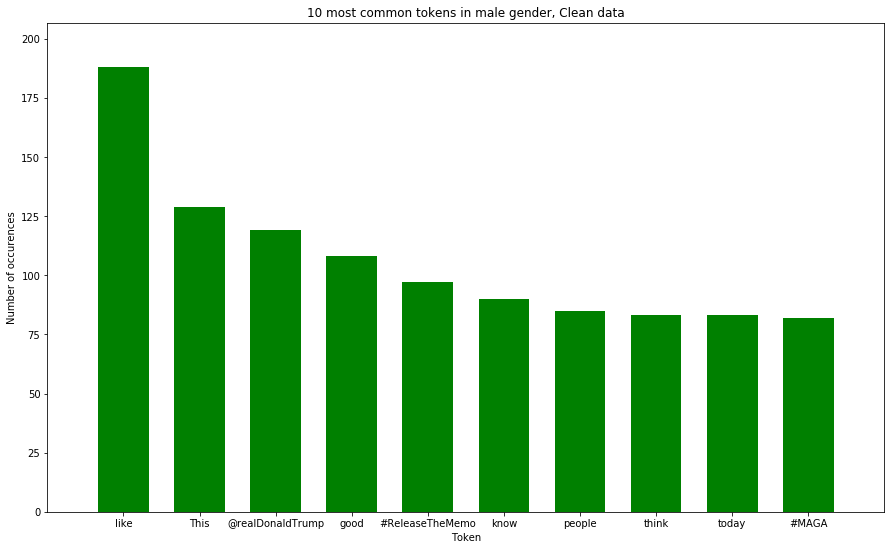

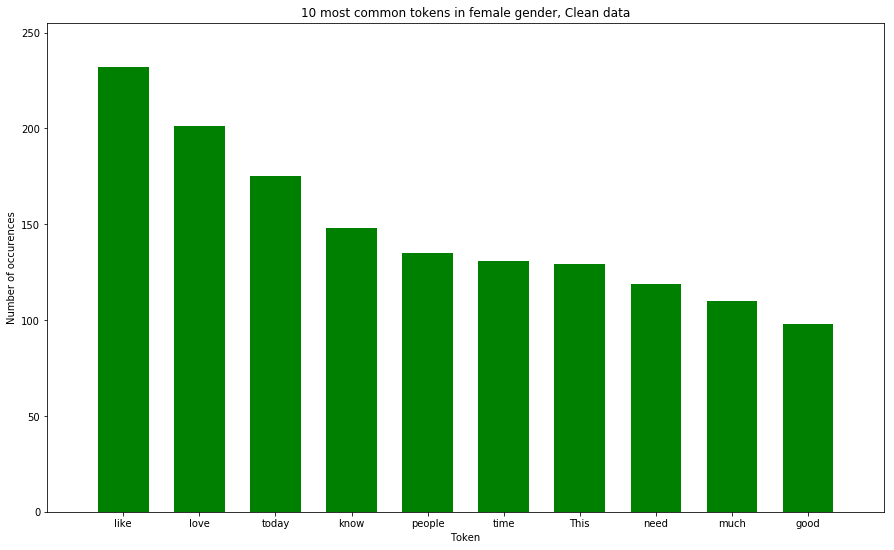

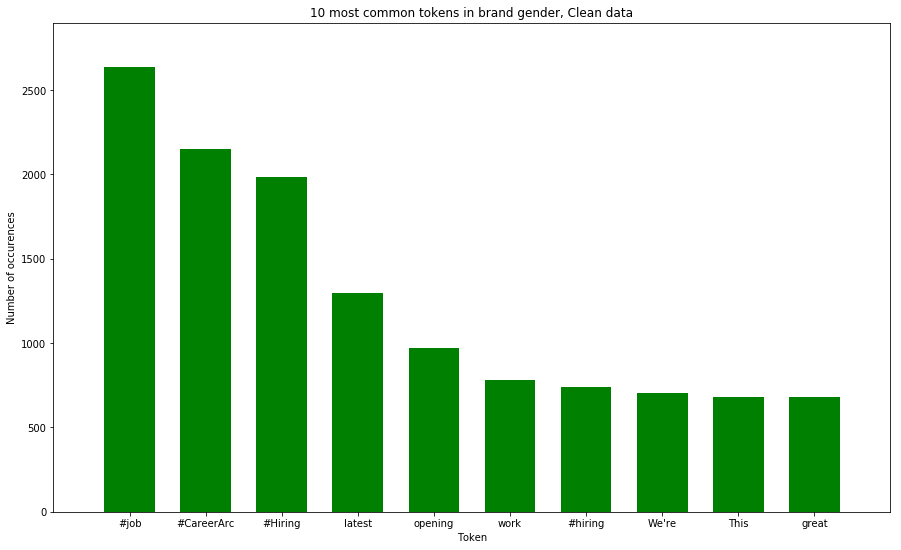

In [155]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


for gender in ['male','female','brand']:
    unzipped = list(zip(*top_10_per_gender_clean[gender]))
    xs = list(unzipped[0])
    ys = list(unzipped[1])

    plt.title('10 most common tokens in {} gender, Clean data'.format(gender))
    plt.ylabel('Number of occurences')
    plt.xlabel('Token')
    plt.axis([-1, len(xs), 0, 1.1*max(ys)])
    plt.xticks(range(len(xs)),xs)
    width = 1/1.5
    plt.bar(range(len(xs)), ys, width, color="green")

    plt.show()

As we can see, the female tweets seem the most "human" out of all 3 genders, with some of the most commonly used words in english also being the most commonly used words in the female tweets data.

On the other hand, the male & especially the brand tweets seem very spammy, with #job exceeding 2500 appearances (out of 5000 collected tweets). This is because i filtered brand tweets by hashtag (and yes i used #job and #career).

The brand tweets are in general a lot more homogenous than the male and female tweets because of my filtering strategy - by collecting tweets via first name instead of a particular hashtag, we could have obtained more diverse tweets spanning more topics and personalities than filtering by a specific hashtag would (e.g. filtering by #NBAFinals would have got us only sports tweets, and a much smaller vocabulary over the male dataset).

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


unzipped = list(zip(*top_10_overall))
xs = list(unzipped[0])
ys = list(unzipped[1])

plt.title('10 most common tokens overall, Clean data')
plt.ylabel('Number of occurences')
plt.xlabel('Token')
plt.axis([-1, len(xs), 0, 1.1*max(ys)])
plt.xticks(range(len(xs)),xs)
width = 1/1.5
plt.bar(range(len(xs)), ys, width, color="green")

plt.show()

## Question 4

Lets run our best model (the text+count-based features model):

In [157]:
pred = pipeline.predict(clean_mined_df)
print(classification_report(clean_mined_df['gender'], pred))
print('Accuracy score: {}'.format(accuracy_score(clean_mined_df['gender'], pred)))

             precision    recall  f1-score   support

      brand       0.77      0.99      0.87      3322
     female       0.79      0.67      0.73      6013
       male       0.68      0.68      0.68      5035

avg / total       0.75      0.75      0.74     14370

Accuracy score: 0.748643006263


As we can see, we did very well - better than our original test set (.734).

Our recall on brand tweets was near perfect, which means our model was well-trained to detect spam-like properties of tweets, causing him to classify tweets as "brand" very frequently, and this conclusion is supported by the recalls of the other 2 categories, which are much lower than the brand recall. In fact, our success with classifying brand tweets is probably responsible for most of the improvement in accuracy, even though we did improve on all metrics with male tweets and female precision got a bit better.

Our performance of female tweets has dropped slightly, which is discouraging because i felt the female tweets that we collected were the least spammy and the most reliable out of all other genders' tweets. Perhaps the ethnic homogeneousness of the first names we chose to filter by, is enough cause to create this slight decrease in performance.

The fact that we mined the male and female tweets filtered by first names, and still got decent results shows that our model is not biased towards the training data, i.e. we do not overfit on the training samples.



## Bibliography
I researched some notoriously strong features for gender classification (not necessarily related to twitter), here are my sources:
        
1. https://www.researchgate.net/publication/216360382_Feature_Selection_for_Gender_Classification
            
2. https://www.researchgate.net/publication/321976491_Age_and_Gender_Classification_of_Tweets_Using_Convolutional_Neural_Networks
        
3. https://cs224d.stanford.edu/reports/BartleAric.pdf
  
4. https://www.researchgate.net/publication/294832065_Using_Sociolinguistic_Inspired_Features_for_Gender_Classification_of_Web_Authors
           
5. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.226.2791&rep=rep1&type=pdf

## Note:
The results could  have improved dramatically (probably would have broken 80% in accuracy) had we, given a username, mined more tweets from that username and considered those tweets in our model (as features).